In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## **Reference 2D diffusion Model**

In [ ]:
# ============================================
# Stable Diffusion class-conditioned generation
# - Colab-ready, single cell
# - Discovers classes from "<class>__..." filenames
# - Generates 25 images/class (5x5 grid) with SD txt2img
# - Optional img2img from first frame per class
# ============================================
!pip -q install --upgrade diffusers==0.30.3 transformers==4.44.2 accelerate==0.34.2 safetensors==0.4.5 pillow==10.4.0

import os, re, math, random, torch
from pathlib import Path
from typing import Dict, List, Optional
from PIL import Image, ImageDraw, ImageFont, ImageOps
from diffusers import StableDiffusionPipeline, StableDiffusionImg2ImgPipeline
from torchvision.utils import make_grid
import numpy as np

# ---------------- Config ----------------
FRAMES_ROOT = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251113_130457/frames")
OUTDIR       = Path("/content/drive/MyDrive/Matreskas/sd_generated")
MODEL_ID     = "runwayml/stable-diffusion-v1-5"   # change if you like
HF_TOKEN     = None  # set to your token string if needed, else keep None
DEVICE       = "cuda" if torch.cuda.is_available() else "cpu"

IMGS_PER_CLASS = 25           # 5x5 grid
SEED           = 42
WIDTH, HEIGHT  = 512, 512
STEPS          = 30
GUIDANCE       = 7.5
NEGATIVE_PROMPT = "low quality, blurry, deformed, watermark, text, logo"
USE_IMG2IMG    = True         # also generate img2img variants from first frame

# Prompt templates (edit to taste)
PROMPT_TPL = {
    "default": "a detailed studio photo of a Matryoshka (nesting) doll, {cls_desc} style, intricate painting, high detail, product photography",
    # Optional specific wording per class; key must match class name to override
    # "russian_authentic": "an authentic Russian Matryoshka doll, {cls_desc}, traditional style, rich patterns, museum lighting, high detail",
}

# -------------- Helpers -----------------
IMG_EXTS = {".jpg",".jpeg",".png",".webp",".bmp",".tif",".tiff"}

def is_image(p: Path)->bool:
    return p.is_file() and p.suffix.lower() in IMG_EXTS

def discover_classes(root: Path) -> Dict[str, List[Path]]:
    """
    Returns {class_name: [frame files ...]} from any files under root
    whose stem looks like "<class>__...".
    """
    assert root.exists(), f"Frames folder not found: {root}"
    class_map: Dict[str, List[Path]] = {}
    for f in root.rglob("*"):
        if not is_image(f): continue
        stem = f.stem
        if "__" in stem:
            cls = stem.split("__",1)[0]
            class_map.setdefault(cls, []).append(f)
    return class_map

def first_frame_for_class(files: List[Path]) -> Optional[Path]:
    return sorted(files)[0] if files else None

def build_prompt(cls: str) -> str:
    base = PROMPT_TPL.get(cls, PROMPT_TPL["default"])
    # a slightly nicer textual description from the class name
    cls_desc = cls.replace("_"," ").replace("-"," ").strip()
    return base.format(cls_desc=cls_desc)

def seed_all(seed=0):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed);
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

def pil_grid(images: List[Image.Image], nrow: int=5, pad: int=2, title: Optional[str]=None) -> Image.Image:
    """Make a grid (like torchvision.make_grid but preserving PIL)."""
    if not images:
        return Image.new("RGB",(512,512),(255,255,255))
    # convert to tensor for tiled concat
    ts = [torch.from_numpy(np.asarray(im.convert("RGB"))).permute(2,0,1) for im in images]
    grid = make_grid(torch.stack(ts), nrow=nrow, padding=pad)  # C,H,W
    grid = grid.permute(1,2,0).cpu().numpy()
    out = Image.fromarray(grid.astype(np.uint8))
    if title:
        # add a small title band
        band_h = 44
        canvas = Image.new("RGB", (out.width, out.height+band_h), (255,255,255))
        canvas.paste(out, (0, band_h))
        draw = ImageDraw.Draw(canvas)
        try:
            font = ImageFont.truetype("DejaVuSans.ttf", 22)
        except:
            font = ImageFont.load_default()
        tw, th = draw.textlength(title, font=font), 20
        draw.text(((canvas.width - tw)//2, (band_h - th)//2), title, fill=(0,0,0), font=font)
        out = canvas
    return out

# -------------- Load pipelines --------------
seed_all(SEED)
print("Loading Stable Diffusion…")
pipe = StableDiffusionPipeline.from_pretrained(
    MODEL_ID,
    torch_dtype=torch.float16 if DEVICE=="cuda" else torch.float32,
    use_auth_token=HF_TOKEN
).to(DEVICE)
pipe.enable_attention_slicing()

pipe_img2img = None
if USE_IMG2IMG:
    print("Loading Img2Img pipeline…")
    pipe_img2img = StableDiffusionImg2ImgPipeline.from_pretrained(
        MODEL_ID,
        torch_dtype=torch.float16 if DEVICE=="cuda" else torch.float32,
        use_auth_token=HF_TOKEN
    ).to(DEVICE)
    pipe_img2img.enable_attention_slicing()

# -------------- Discover classes --------------
classes = discover_classes(FRAMES_ROOT)
assert classes, f"No classes discovered under {FRAMES_ROOT}. Ensure filenames contain '<class>__...'"
print("Classes:", sorted(classes.keys()))

OUTDIR.mkdir(parents=True, exist_ok=True)

# -------------- Generate per class --------------
for cls, files in classes.items():
    cls_dir = OUTDIR / cls
    cls_dir.mkdir(parents=True, exist_ok=True)

    prompt = build_prompt(cls)
    print(f"\n=== Generating for class: {cls} ===")
    print("Prompt:", prompt)

    # --- TXT2IMG ---
    txt2img_samples = []
    for i in range(IMGS_PER_CLASS):
        g = torch.Generator(device=DEVICE).manual_seed(SEED + i)
        img = pipe(
            prompt=prompt,
            negative_prompt=NEGATIVE_PROMPT,
            num_inference_steps=STEPS,
            guidance_scale=GUIDANCE,
            height=HEIGHT, width=WIDTH,
            generator=g
        ).images[0]
        out_path = cls_dir / f"sd_txt2img_{cls}_{i:03d}.png"
        img.save(out_path)
        txt2img_samples.append(img)

    grid_txt2img = pil_grid(txt2img_samples, nrow=5, title=f"{cls} — SD txt2img (n={IMGS_PER_CLASS})")
    grid_txt2img.save(cls_dir / f"grid_txt2img_{cls}_5x5.png")

    # --- IMG2IMG (optional, from first frame) ---
    if USE_IMG2IMG:
        ref = first_frame_for_class(files)
        if ref is not None:
            base = Image.open(ref).convert("RGB")
            # center-square crop then resize to target
            w,h = base.size
            m = min(w,h)
            base = base.crop(((w-m)//2, (h-m)//2, (w+m)//2, (h+m)//2)).resize((WIDTH, HEIGHT), Image.BICUBIC)

            img2img_samples = []
            strength = 0.65  # how much to deviate from the reference (0=copy, 1=ignore)
            for i in range(IMGS_PER_CLASS):
                g = torch.Generator(device=DEVICE).manual_seed(SEED + 10_000 + i)
                out = pipe_img2img(
                    prompt=prompt,
                    negative_prompt=NEGATIVE_PROMPT,
                    image=base,
                    strength=strength,
                    num_inference_steps=STEPS,
                    guidance_scale=GUIDANCE,
                    generator=g
                ).images[0]
                out_path = cls_dir / f"sd_img2img_{cls}_{i:03d}.png"
                out.save(out_path)
                img2img_samples.append(out)

            grid_img2img = pil_grid(img2img_samples, nrow=5, title=f"{cls} — SD img2img (n={IMGS_PER_CLASS})")
            grid_img2img.save(cls_dir / f"grid_img2img_{cls}_5x5.png")
        else:
            print(f"[warn] No seed frame found for img2img in class {cls}")

print("\nDone.")
print(f"Outputs saved under: {OUTDIR.as_posix()}")


Loading Stable Diffusion…


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

Keyword arguments {'use_auth_token': None} are not expected by StableDiffusionPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Loading Img2Img pipeline…


Keyword arguments {'use_auth_token': None} are not expected by StableDiffusionImg2ImgPipeline and will be ignored.


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Classes: ['artistic', 'drafted', 'merchandise', 'non_authentic', 'non_matreskas', 'political', 'religious', 'russian_authentic']

=== Generating for class: artistic ===
Prompt: a detailed studio photo of a Matryoshka (nesting) doll, artistic style, intricate painting, high detail, product photography


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

/tmp/ipython-input-2333041198.py:79: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /pytorch/torch/csrc/utils/tensor_numpy.cpp:203.)
  ts = [torch.from_numpy(np.asarray(im.convert("RGB"))).permute(2,0,1) for im in images]


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


=== Generating for class: drafted ===
Prompt: a detailed studio photo of a Matryoshka (nesting) doll, drafted style, intricate painting, high detail, product photography


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/19 [00:00<?, ?it/s]


=== Generating for class: merchandise ===
Prompt: a detailed studio photo of a Matryoshka (nesting) doll, merchandise style, intricate painting, high detail, product photography


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


=== Generating for class: non_matreskas ===
Prompt: a detailed studio photo of a Matryoshka (nesting) doll, non matreskas style, intricate painting, high detail, product photography


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


=== Generating for class: non_authentic ===
Prompt: a detailed studio photo of a Matryoshka (nesting) doll, non authentic style, intricate painting, high detail, product photography


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


=== Generating for class: political ===
Prompt: a detailed studio photo of a Matryoshka (nesting) doll, political style, intricate painting, high detail, product photography


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/19 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


=== Generating for class: religious ===
Prompt: a detailed studio photo of a Matryoshka (nesting) doll, religious style, intricate painting, high detail, product photography


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


=== Generating for class: russian_authentic ===
Prompt: a detailed studio photo of a Matryoshka (nesting) doll, russian authentic style, intricate painting, high detail, product photography


  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

Potential NSFW content was detected in one or more images. A black image will be returned instead. Try again with a different prompt and/or seed.


  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]


Done.
Outputs saved under: /content/drive/MyDrive/Matreskas/sd_generated


>>> VIDEO TO MESH PIPELINE STARTED <<<
Mounted at /content/drive
Installing dependencies (ffmpeg, pyvista, colmap)...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.1/245.1 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 4.0 MB/s eta 0:00:00

Using COLMAP from apt-get...
✅ COLMAP (apt) available.
✅ GPU available: NVIDIA A100-SXM4-40GB
    Memory: 39.6 GB
✅ Video found: /content/drive/MyDrive/Matreskas/Videos/Artistic/IMG_4783.MOV
    Size: 54.5 MB
[06:18:12] 📹 Extracting frames from video: IMG_4783.MOV
[06:18:12]   Video duration: 31.0 seconds
[06:18:12]   Expected frames: ~62 frames at 2 fps
[06:18:12] RUN: ffmpeg -i /content/drive/MyDrive/Matreskas/Videos/Artistic/IMG_4783.MOV -q:v 2 -frames:v 100 -start_number 0 -vf fps=2,scale=1920:-1 /content/video_frames/frame

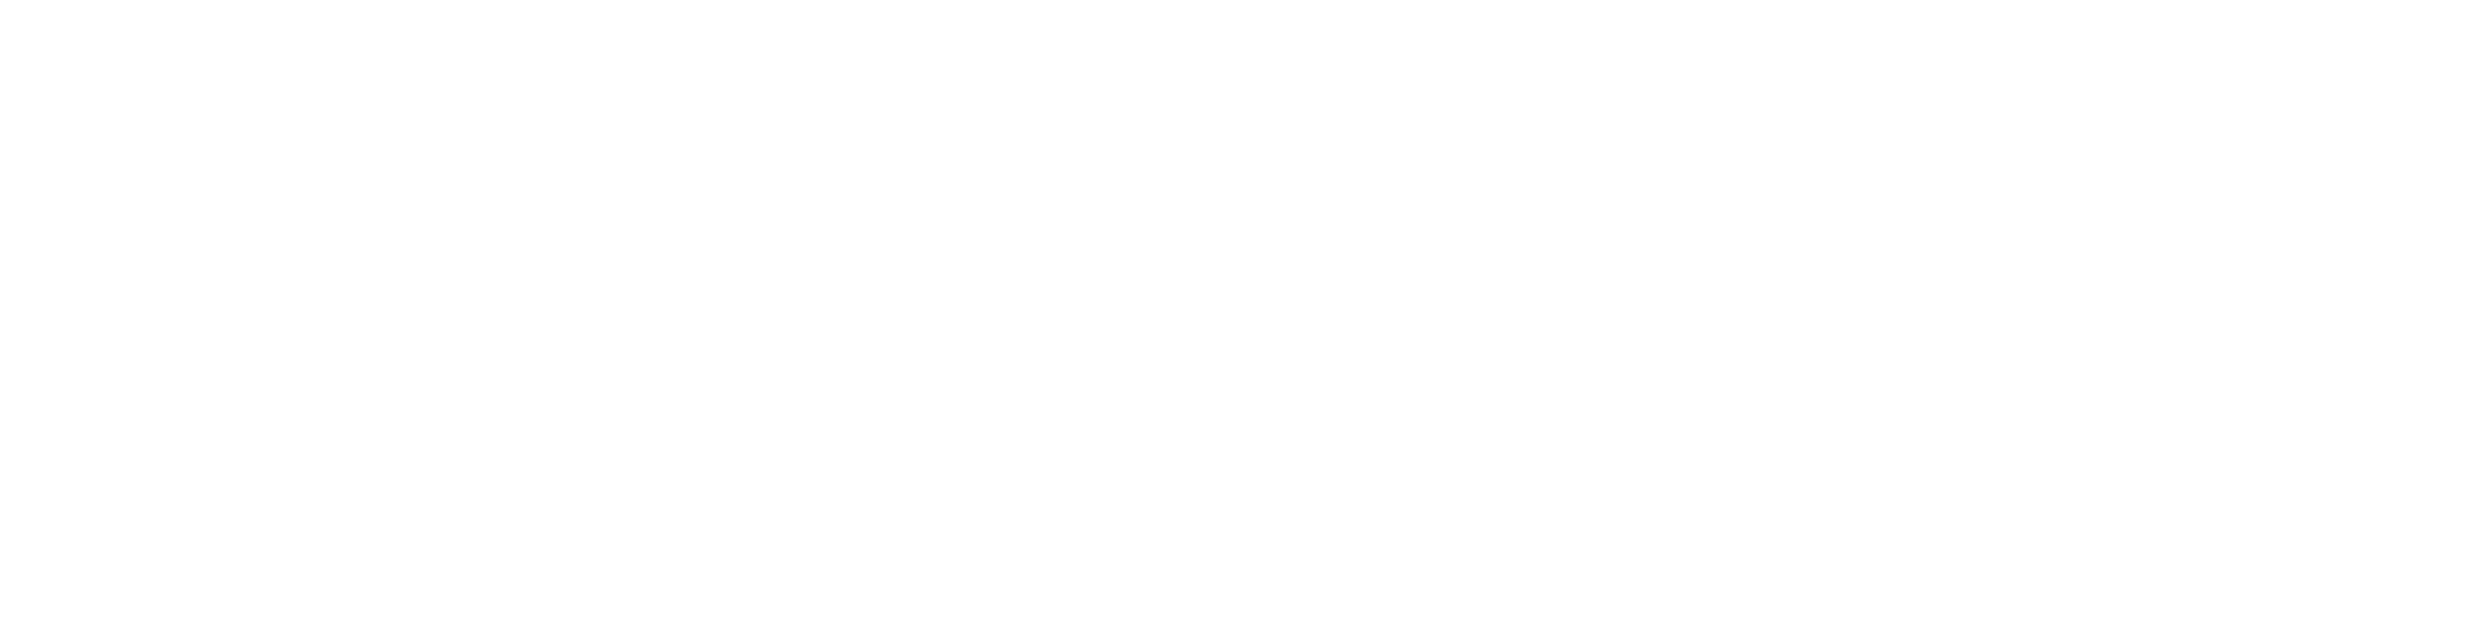


>>> VIDEO TO MESH PIPELINE FINISHED <<<


In [ ]:
# ============================================
# VIDEO TO 3D MESH - COLMAP Pipeline (FIXED FINAL VERSION v2)
# ============================================

print(">>> VIDEO TO MESH PIPELINE STARTED <<<")

# 0) Mount Drive + Install dependencies
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, shutil, subprocess, json, time
from pathlib import Path
from typing import List

# Install dependencies
print("Installing dependencies (ffmpeg, pyvista, colmap)...")
!apt-get -qq update
!apt-get -qq install -y ffmpeg colmap >/dev/null 2>&1

# Install pyvista and trame components separately
!pip -q install pyvista panel trame pillow

# --- COLMAP executable (from apt) ---
print("\nUsing COLMAP from apt-get...")
COLMAP_EXE = "colmap"

# Quick sanity check
!$COLMAP_EXE -h > /dev/null
print("✅ COLMAP (apt) available.")

# Check GPU
import torch
if torch.cuda.is_available():
    print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"    Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️ No GPU detected, will use CPU (slower)")

from PIL import Image, ImageOps
import pyvista as pv
from IPython.display import display

# 1) CONFIG ---------------------------------------------------------------
# --- ⬇️ PLEASE SET YOUR VIDEO PATH HERE ---
VIDEO_PATH = Path("/content/drive/MyDrive/Matreskas/Videos/Artistic/IMG_4783.MOV")
# --- ⬆️ PLEASE SET YOUR VIDEO PATH HERE ---

OUT_ROOT = Path("/content/mesh_output")
FRAMES_DIR = Path("/content/video_frames")
VIS_DIR = OUT_ROOT / "visualizations" # Directory for snapshots

# Frame extraction settings
EXTRACT_FPS = 2           # Extract 2 frames per second
MAX_FRAMES = 100          # Maximum frames to extract
FRAME_QUALITY = 2         # JPEG quality (1-31, lower is better)
RESIZE_WIDTH = 1920       # Resize frames to this width (None = keep original)

# COLMAP settings
MAX_IMAGE_SIZE = 1600     # Max size for reconstruction
SIFT_MAX_FEATURES = 8000  # Number of features per image

# 2) HELPERS --------------------------------------------------------------
def log(msg):
    print(f"[{time.strftime('%H:%M:%S')}] {msg}", flush=True)

def run(cmd, cwd=None, check=True, show_output=False):
    if isinstance(cmd, str):
        cmd = cmd.split()

    # Use the correct COLMAP executable path
    if cmd[0] == "colmap":
        cmd[0] = COLMAP_EXE

    log("RUN: " + " ".join(cmd))

    # Set environment variables to run COLMAP headlessly
    env = os.environ.copy()
    env['QT_QPA_PLATFORM'] = 'offscreen'
    env['DISPLAY'] = ''

    p = subprocess.run(cmd, cwd=cwd, text=True, capture_output=True, env=env)

    if p.stdout.strip():
        if show_output:
            print(p.stdout)
        else:
            # Print only key lines to avoid spam
            for line in p.stdout.split('\n'):
                if any(keyword in line.lower() for keyword in ['error', 'warning', 'elapsed', 'registered', 'points', 'images', 'frame=']):
                    print(f"  → {line}")

    if p.returncode and p.stderr.strip():
        print("STDERR:\n" + p.stderr[:2000])

    if check and p.returncode != 0:
        raise RuntimeError(f"Command failed with exit code: {p.returncode}")

    return p.returncode == 0

# 3) EXTRACT FRAMES FROM VIDEO ------------------------------------
def extract_frames_from_video(video_path: Path, output_dir: Path):
    log(f"📹 Extracting frames from video: {video_path.name}")

    # Clean and create output directory
    if output_dir.exists():
        shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True)

    # Get video info
    probe_cmd = [
        "ffprobe", "-v", "error",
        "-select_streams", "v:0",
        "-count_packets", "-show_entries",
        "stream=nb_read_packets,r_frame_rate,duration",
        "-of", "json", str(video_path)
    ]

    probe = subprocess.run(probe_cmd, capture_output=True, text=True)
    if probe.returncode == 0:
        info = json.loads(probe.stdout)
        if info.get('streams'):
            stream = info['streams'][0]
            duration = float(stream.get('duration', 0))
            log(f"  Video duration: {duration:.1f} seconds")
            log(f"  Expected frames: ~{int(duration * EXTRACT_FPS)} frames at {EXTRACT_FPS} fps")

    # Build ffmpeg command
    ffmpeg_cmd = [
        "ffmpeg",
        "-i", str(video_path),
        "-q:v", str(FRAME_QUALITY),
        "-frames:v", str(MAX_FRAMES),
        "-start_number", "0"
    ]

    # Build filter string
    filters = [f"fps={EXTRACT_FPS}"]
    if RESIZE_WIDTH:
        filters.append(f"scale={RESIZE_WIDTH}:-1")

    # Add video filter
    ffmpeg_cmd.extend(["-vf", ",".join(filters)])

    # Add output pattern
    ffmpeg_cmd.append(str(output_dir / "frame_%04d.jpg"))

    # Run extraction
    if not run(ffmpeg_cmd, show_output=True):
        raise RuntimeError("Frame extraction failed")

    # Count extracted frames
    frames = sorted(output_dir.glob("*.jpg"))
    log(f"✅ Extracted {len(frames)} frames")

    # Show sample frame info
    if frames:
        sample = Image.open(frames[0])
        log(f"  Frame size: {sample.size[0]}x{sample.size[1]}")

    return frames

# 4) RUN COLMAP RECONSTRUCTION (FIXED) -----------------------------------
def run_colmap_reconstruction(frames_dir: Path, output_dir: Path):
    log("🚀 Starting 3D reconstruction with COLMAP")

    # Setup directories
    sparse_dir = output_dir / "sparse"
    dense_dir = output_dir / "dense"
    db_path = output_dir / "database.db"

    for d in [sparse_dir, dense_dir]:
        d.mkdir(parents=True, exist_ok=True)

    # Step 1: Feature extraction (CPU)
    log("Step 1/7: Feature extraction (CPU-mode)")
    if not run([
        "colmap", "feature_extractor",
        "--database_path", str(db_path),
        "--image_path", str(frames_dir),
        "--SiftExtraction.use_gpu", "0",  # CPU to avoid OpenGL crash
        "--SiftExtraction.max_num_features", str(SIFT_MAX_FEATURES),
        "--SiftExtraction.first_octave", "0",
        "--ImageReader.single_camera", "1",
        "--ImageReader.camera_model", "SIMPLE_PINHOLE"
    ]):
        raise RuntimeError("Feature extraction failed")

    # Step 2: Feature matching (CPU)
    log("Step 2/7: Feature matching (CPU-mode)")
    success = False
    try:
        # 🔧 FIX: disable loop detection (no vocab_tree required)
        success = run([
            "colmap", "sequential_matcher",
            "--database_path", str(db_path),
            "--SiftMatching.use_gpu", "0",
            "--SequentialMatching.overlap", "20",
            "--SequentialMatching.loop_detection", "0"
        ], check=False)
    except:
        success = False

    if not success:
        log("Sequential matching failed, trying exhaustive...")
        if not run([
            "colmap", "exhaustive_matcher",
            "--database_path", str(db_path),
            "--SiftMatching.use_gpu", "0",
            "--SiftMatching.num_threads", "8"
        ]):
            raise RuntimeError("Feature matching failed")

    # Step 3: Sparse reconstruction
    log("Step 3/7: Sparse reconstruction (SfM)")
    if not run([
        "colmap", "mapper",
        "--database_path", str(db_path),
        "--image_path", str(frames_dir),
        "--output_path", str(sparse_dir),
        "--Mapper.num_threads", "8",
        "--Mapper.init_min_num_inliers", "100",
        "--Mapper.init_max_error", "4",
    ]):
        raise RuntimeError("Sparse reconstruction failed")

    # Find best model
    models = [d for d in sparse_dir.iterdir() if d.is_dir() and any(d.iterdir())]
    if not models:
        raise RuntimeError("No sparse model generated")

    model_dir = models[0]
    log(f"Using model: {model_dir.name}")

    # Export sparse point cloud
    log("Exporting sparse point cloud")
    sparse_ply = output_dir / "sparse.ply"
    run([
        "colmap", "model_converter",
        "--input_path", str(model_dir),
        "--output_path", str(sparse_ply),
        "--output_type", "PLY"
    ], check=False)

    # Step 4: Image undistortion
    log("Step 4/7: Image undistortion for MVS")
    if not run([
        "colmap", "image_undistorter",
        "--image_path", str(frames_dir),
        "--input_path", str(model_dir),
        "--output_path", str(dense_dir),
        "--output_type", "COLMAP",
        "--max_image_size", str(MAX_IMAGE_SIZE)
    ]):
        raise RuntimeError("Image undistortion failed")

    # Step 5: Dense reconstruction
    log("Step 5/7: Dense stereo reconstruction (CPU-mode)")
    # Note: apt-get COLMAP may not have CUDA, so we avoid forcing GPU here.
    if not run([
        "colmap", "patch_match_stereo",
        "--workspace_path", str(dense_dir),
        "--workspace_format", "COLMAP",
        "--PatchMatchStereo.geom_consistency", "1",
        "--PatchMatchStereo.num_samples", "15",
        "--PatchMatchStereo.num_iterations", "5"
    ], check=False):
        log("⚠️ Dense stereo failed, continuing with sparse only...")

    # Step 6: Stereo fusion
    log("Step 6/7: Stereo fusion")
    dense_ply = dense_dir / "fused.ply"
    if run([
        "colmap", "stereo_fusion",
        "--workspace_path", str(dense_dir),
        "--workspace_format", "COLMAP",
        "--input_type", "geometric",
        "--output_path", str(dense_ply),
        "--StereoFusion.min_num_pixels", "3"
    ], check=False):
        log("✅ Dense point cloud created")
    else:
        log("⚠️ Stereo fusion failed; dense point cloud not available.")

    # Step 7: Mesh / point-cloud selection for visualization
    log("Step 7/7: Selecting mesh/point cloud for visualization")

    final_mesh_path = None
    if dense_ply.exists() and dense_ply.stat().st_size > 10000:
        log("Trying Poisson mesh reconstruction...")
        poisson_path = output_dir / "mesh_poisson.ply"
        if run([
            "colmap", "poisson_mesher",
            "--input_path", str(dense_ply),
            "--output_path", str(poisson_path),
            "--PoissonMesher.depth", "10",
            "--PoissonMesher.trim", "7"
        ], check=False):
            log("✅ Poisson mesh generated")
            final_mesh_path = poisson_path

        # Also try Delaunay
        log("Trying Delaunay mesh reconstruction...")
        delaunay_path = output_dir / "mesh_delaunay.ply"
        if run([
            "colmap", "delaunay_mesher",
            "--input_path", str(dense_dir),
            "--output_path", str(delaunay_path),
        ], check=False):
            log("✅ Delaunay mesh generated")
            if not final_mesh_path: # Use as fallback
                final_mesh_path = delaunay_path
    else:
        log("⚠️ Dense reconstruction unavailable.")

    # Fallback: if no mesh but we have sparse.ply, visualize that
    if not final_mesh_path and sparse_ply.exists():
        log("ℹ️ Using sparse point cloud for visualization.")
        final_mesh_path = sparse_ply
    elif not final_mesh_path:
        log("⚠️ No dense or sparse PLY file found; nothing to visualize.")

    return output_dir, final_mesh_path

# 5) VISUALIZE MESH --------------------------------------------------------
def visualize_mesh(mesh_path: Path, output_dir: Path):
    if not mesh_path or not mesh_path.exists():
        log("No mesh file found to visualize.")
        return

    log(f"🎨 Generating snapshots for {mesh_path.name}")
    output_dir.mkdir(parents=True, exist_ok=True)

    # Set up headless (off-screen) plotting
    pv.set_plot_theme("document")
    plotter = pv.Plotter(off_screen=True, window_size=[600, 600])

    # Load mesh or point cloud
    mesh = pv.read(mesh_path)
    plotter.add_mesh(mesh, color='white', smooth_shading=True, specular=1.0)

    # Auto-center camera
    plotter.camera.zoom(1.2)

    # List to hold image paths
    image_paths = []

    # --- View 1: Front ---
    plotter.camera_position = 'xy'
    plotter.camera.elevation = 0
    img_path = output_dir / "01_front.png"
    plotter.screenshot(img_path)
    image_paths.append(img_path)

    # --- View 2: Side ---
    plotter.camera.azimuth = 90
    img_path = output_dir / "02_side.png"
    plotter.screenshot(img_path)
    image_paths.append(img_path)

    # --- View 3: Other Side ---
    plotter.camera.azimuth = 270
    img_path = output_dir / "03_side_other.png"
    plotter.screenshot(img_path)
    image_paths.append(img_path)

    # --- View 4: Top ---
    plotter.camera_position = 'xz'
    plotter.camera.elevation = 0
    img_path = output_dir / "04_top.png"
    plotter.screenshot(img_path)
    image_paths.append(img_path)

    plotter.close()

    # --- Display images in Colab ---
    print("\n📸 Mesh Snapshots:")
    pil_images = []
    for p in image_paths:
        img = Image.open(p)
        img_with_border = ImageOps.expand(img, border=10, fill='white')
        pil_images.append(img_with_border)

    if pil_images:
        widths, heights = zip(*(i.size for i in pil_images))
        total_width = sum(widths)
        max_height = max(heights)

        composite_img = Image.new('RGB', (total_width, max_height), (255, 255, 255))

        x_offset = 0
        for im in pil_images:
            composite_img.paste(im, (x_offset, 0))
            x_offset += im.size[0]

        display(composite_img)

# 6) MAIN PIPELINE --------------------------------------------------------
def main():
    # Validate video path
    if not VIDEO_PATH.exists():
        print(f"❌ Video not found: {VIDEO_PATH}")
        print("\n📁 Available videos in parent directory:")
        parent = VIDEO_PATH.parent
        if parent.exists():
            for v in parent.glob("*.MOV"):
                print(f"  - {v.name}")
            for v in parent.glob("*.mp4"):
                print(f"  - {v.name}")
        raise SystemExit("Please check the video path!")

    print(f"✅ Video found: {VIDEO_PATH}")
    print(f"    Size: {VIDEO_PATH.stat().st_size / (1024**2):.1f} MB")

    # Create output directories
    OUT_ROOT.mkdir(parents=True, exist_ok=True)

    final_mesh_path = None
    try:
        # Extract frames
        frames = extract_frames_from_video(VIDEO_PATH, FRAMES_DIR)

        if len(frames) < 10:
            raise RuntimeError(f"Too few frames extracted ({len(frames)}). Need at least 10.")

        # Run COLMAP reconstruction
        result_dir, final_mesh_path = run_colmap_reconstruction(FRAMES_DIR, OUT_ROOT)

        # Show results
        print("\n" + "="*60)
        print("✅ RECONSTRUCTION COMPLETE!")
        print("="*60)

        # List generated files
        print("\n📦 Generated files:")
        total_size = 0
        for ext in ['*.ply', '*.bin', '*.txt']:
            for f in OUT_ROOT.rglob(ext):
                size_mb = f.stat().st_size / (1024**2)
                total_size += size_mb
                rel_path = f.relative_to(OUT_ROOT)

                if "sparse.ply" == f.name:
                    icon = "🟡"
                elif "fused.ply" in f.name:
                    icon = "🟢"
                elif "mesh" in f.name:
                    icon = "🔵"
                else:
                    continue

                if size_mb > 0.01:
                    print(f"{icon} {rel_path}: {size_mb:.2f} MB")

        print(f"\n📊 Total size: {total_size:.1f} MB")

        # Save summary
        with open(OUT_ROOT / "summary.json", "w") as f:
            json.dump({"video": str(VIDEO_PATH), "frames_extracted": len(frames)}, f, indent=2)

        print("\n💾 To download the mesh/point cloud:")
        print("!zip -r mesh_result.zip /content/mesh_output")

    except Exception as e:
        print(f"\n❌ Pipeline failed: {e}")
        import traceback
        traceback.print_exc()

    finally:
        # Optional: Clean up frames to save space
        if FRAMES_DIR.exists():
            frame_count = len(list(FRAMES_DIR.glob('*')))
            if frame_count > 0:
                log(f"Cleaning up {frame_count} temporary frames...")
                shutil.rmtree(FRAMES_DIR)

        # --- Run Visualization ---
        if final_mesh_path:
            visualize_mesh(final_mesh_path, VIS_DIR)
        else:
            log("No final mesh was created, skipping visualization.")

# Run the pipeline
if __name__ == "__main__":
    main()
    print("\n>>> VIDEO TO MESH PIPELINE FINISHED <<<")


In [ ]:
!pip install -q trimesh[png] pyglet

from pathlib import Path

OUT_ROOT = Path("/content/mesh_output")
ply_files = list(OUT_ROOT.rglob("*.ply"))

print(f"Found {len(ply_files)} PLY files:\n")
for i, f in enumerate(ply_files):
    print(f"[{i}] {f}  ({round(f.stat().st_size/1024**2, 3)} MB)")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 61.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 57.1 MB/s eta 0:00:00
Found 2 PLY files:

[0] /content/mesh_output/sparse.ply  (0.538 MB)
[1] /content/mesh_output/dense/fused.ply  (0.0 MB)


In [ ]:
import trimesh
from IPython.display import Image, display

# 👇 change this if you want a different file
mesh_index = 0   # e.g., 0 for the first PLY in the list above

mesh_path = ply_files[mesh_index]
print("Using:", mesh_path)

geom = trimesh.load(mesh_path, process=False)
print("Loaded geometry type:", type(geom))

# Print some basic info
if isinstance(geom, trimesh.Trimesh):
    print("Trimesh:", geom.vertices.shape[0], "vertices,", geom.faces.shape[0], "faces")
elif isinstance(geom, trimesh.points.PointCloud):
    print("PointCloud:", geom.vertices.shape[0], "points")
else:
    print("Scene or other geometry with", len(getattr(geom, "geometry", [])), "sub-geometries")


Using: /content/mesh_output/sparse.ply
Loaded geometry type: <class 'trimesh.points.PointCloud'>
PointCloud: 37590 points


In [ ]:
!pip install glu

In [ ]:
!pip install "pyglet<2"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 60.0 MB/s eta 0:00:00
  Attempting uninstall: pyglet
    Found existing installation: pyglet 2.1.11
    Uninstalling pyglet-2.1.11:
      Successfully uninstalled pyglet-2.1.11


In [ ]:
import struct
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Path to uploaded PLY
ply_path = Path("/content/mesh_output/sparse.ply")
assert ply_path.exists(), f"{ply_path} not found"

# --- Parse binary PLY header ---
with open(ply_path, "rb") as f:
    header_lines = []
    while True:
        line = f.readline()
        header_lines.append(line)
        if line.strip() == b"end_header":
            break
    header_bytes = b"".join(header_lines)
    header_text = header_bytes.decode("ascii", errors="ignore")

header_text


'ply\nformat binary_little_endian 1.0\nelement vertex 37590\nproperty float x\nproperty float y\nproperty float z\nproperty uchar red\nproperty uchar green\nproperty uchar blue\nend_header\n'

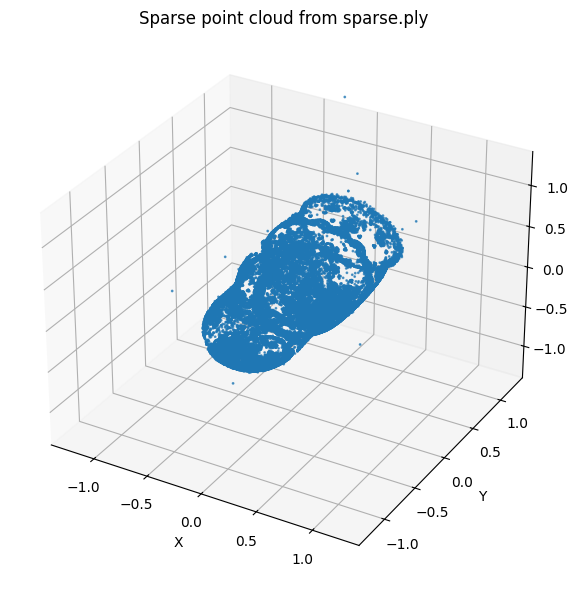

In [ ]:
import struct
from pathlib import Path

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Path to uploaded PLY
ply_path = Path("/content/mesh_output/sparse.ply")
assert ply_path.exists(), f"{ply_path} not found"

# --- Parse binary PLY header ---
with open(ply_path, "rb") as f:
    header_lines = []
    while True:
        line = f.readline()
        header_lines.append(line)
        if line.strip() == b"end_header":
            break
    header_bytes = b"".join(header_lines)
    header_text = header_bytes.decode("ascii", errors="ignore")

# Extract number of vertices from header
num_verts = 0
for line in header_text.splitlines():
    if line.startswith("element vertex"):
        num_verts = int(line.split()[-1])
        break

# Now read the vertex data (binary_little_endian, 3 floats + 3 uchar: x,y,z,r,g,b)
record_size = struct.calcsize("<fffBBB")
xs, ys, zs = [], [], []

with open(ply_path, "rb") as f:
    # Skip header
    f.read(len(header_bytes))
    for _ in range(num_verts):
        data = f.read(record_size)
        if len(data) < record_size:
            break
        x, y, z, r, g, b = struct.unpack("<fffBBB", data)
        xs.append(x)
        ys.append(y)
        zs.append(z)

# --- Center and normalize for nicer viewing ---
import numpy as np

verts = np.column_stack([xs, ys, zs])
center = verts.mean(axis=0)
verts_centered = verts - center

scale = np.percentile(np.linalg.norm(verts_centered, axis=1), 95)
if scale > 0:
    verts_centered /= scale

# --- Plot with matplotlib (no OpenGL needed) ---
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(
    verts_centered[:, 0],
    verts_centered[:, 1],
    verts_centered[:, 2],
    s=1,
    alpha=0.7,
)

ax.set_title(f"Sparse point cloud from {ply_path.name}")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

# Equal aspect ratio
max_range = (verts_centered.max(axis=0) - verts_centered.min(axis=0)).max() / 2.0
mid = verts_centered.mean(axis=0)
ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

plt.tight_layout()
plt.show()


Using sparse point cloud: /content/mesh_output/sparse.ply exists: True
Loaded type: <class 'trimesh.points.PointCloud'>
Input geometry: PointCloud with 37590 points

Building convex hull mesh (this may take a few seconds)...
Hull: vertices = 75 faces = 146
✅ Saved hull mesh to: /content/mesh_output/mesh_hull_trimesh.ply


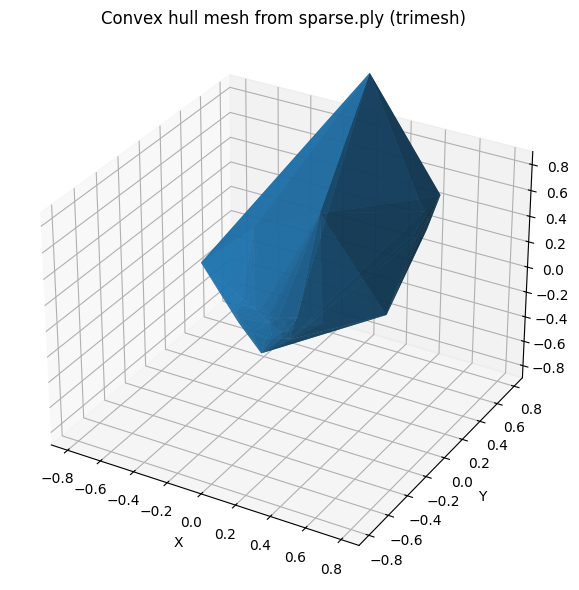


💾 To download hull only:
!zip -r /content/mesh_hull_trimesh.zip /content/mesh_output/mesh_hull_trimesh.ply


In [ ]:
!pip install -q trimesh

from pathlib import Path
import trimesh
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

OUT_ROOT = Path("/content/mesh_output")
sparse_path = OUT_ROOT / "sparse.ply"

print("Using sparse point cloud:", sparse_path, "exists:", sparse_path.exists())
if not sparse_path.exists():
    raise SystemExit("sparse.ply not found. Make sure the COLMAP pipeline ran and produced it.")

# 1) Load sparse.ply with trimesh
geom = trimesh.load(sparse_path, process=False)
print("Loaded type:", type(geom))

# If it's a Scene, pull out first geometry
if isinstance(geom, trimesh.Scene):
    if not geom.geometry:
        raise SystemExit("Scene has 0 sub-geometries – sparse.ply appears empty.")
    name, sub = list(geom.geometry.items())[0]
    print(f"Scene with {len(geom.geometry)} parts, using geometry: {name}")
    geom = sub

# Extract vertices from Trimesh or PointCloud
if isinstance(geom, trimesh.Trimesh):
    verts = np.asarray(geom.vertices)
    print("Input geometry: Trimesh with", verts.shape[0], "vertices,", geom.faces.shape[0], "faces")
elif isinstance(geom, trimesh.points.PointCloud):
    verts = np.asarray(geom.vertices)
    print("Input geometry: PointCloud with", verts.shape[0], "points")
else:
    try:
        verts = np.asarray(geom.vertices)
        print("Input geometry:", type(geom), "with", verts.shape[0], "vertices")
    except Exception as e:
        raise SystemExit(f"Cannot get vertices from {type(geom)}: {e}")

if verts.size == 0:
    raise SystemExit("sparse.ply has 0 vertices – nothing to mesh.")

# 2) Build convex hull mesh
print("\nBuilding convex hull mesh (this may take a few seconds)...")
if isinstance(geom, trimesh.Trimesh):
    hull = geom.convex_hull
else:
    hull = trimesh.Trimesh(vertices=verts, process=False).convex_hull

print("Hull: vertices =", hull.vertices.shape[0], "faces =", hull.faces.shape[0])

# 3) Export hull to PLY
hull_path = OUT_ROOT / "mesh_hull_trimesh.ply"
hull.export(hull_path)
print("✅ Saved hull mesh to:", hull_path)

# 4) Visualize hull mesh with matplotlib (no OpenGL)
hverts = hull.vertices
hfaces = hull.faces

# Center + normalize for nicer view
center = hverts.mean(axis=0)
hverts_centered = hverts - center
scale = np.percentile(np.linalg.norm(hverts_centered, axis=1), 95)
if scale > 0:
    hverts_centered /= scale

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection="3d")

ax.plot_trisurf(
    hverts_centered[:, 0],
    hverts_centered[:, 1],
    hverts_centered[:, 2],
    triangles=hfaces,
    linewidth=0.1,
    alpha=0.8
)

ax.set_title("Convex hull mesh from sparse.ply (trimesh)")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")

max_range = (hverts_centered.max(axis=0) - hverts_centered.min(axis=0)).max() / 2.0
mid = hverts_centered.mean(axis=0)
ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

plt.tight_layout()
plt.show()

print("\n💾 To download hull only:")
print("!zip -r /content/mesh_hull_trimesh.zip /content/mesh_output/mesh_hull_trimesh.ply")


In [ ]:
# ============================================
# VIDEO TO 3D MESH with CUDA COLMAP (Dense + Poisson)
# Colab-ready, headless, uses trimesh + matplotlib for viz
# ============================================

print(">>> CUDA COLMAP VIDEO→MESH PIPELINE STARTED <<<")

# 0) Mount Drive ----------------------------------------------------------
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, shutil, subprocess, json, time
from pathlib import Path
from typing import List

# 1) BUILD COLMAP WITH CUDA -----------------------------------------------
print("\n=== Step 0: Install deps & build CUDA-enabled COLMAP ===")

# Remove any old apt-get COLMAP to avoid confusion
!apt-get -qq remove -y colmap >/dev/null 2>&1 || true

# Core build + COLMAP deps (headless, GUI disabled)
!apt-get -qq update
!apt-get -qq install -y git cmake ninja-build build-essential \
    libboost-all-dev libgoogle-glog-dev libgflags-dev \
    libfreeimage-dev libatlas-base-dev libsuitesparse-dev \
    libeigen3-dev libceres-dev libcgal-dev >/dev/null 2>&1

# Check CUDA toolkit presence (Colab usually has /usr/local/cuda)
!nvcc --version || echo "⚠️ nvcc not found, but CUDA runtime should still be present."

# Clone COLMAP (if not already)
COLMAP_SRC_DIR = Path("/content/colmap")
if not COLMAP_SRC_DIR.exists():
    !git clone --depth 1 https://github.com/colmap/colmap.git /content/colmap

# Configure + build (headless, CUDA on, GUI off)
%cd /content/colmap
!cmake -S . -B build -GNinja \
    -DCMAKE_BUILD_TYPE=Release \
    -DGUI_ENABLED=OFF \
    -DCUDA_ENABLED=ON >/dev/null

!cmake --build build --target colmap -j$(nproc)
COLMAP_EXE = "/content/colmap/build/src/exe/colmap"

# Quick sanity check
!$COLMAP_EXE -h > /dev/null
print("✅ Built CUDA-enabled COLMAP at", COLMAP_EXE)

# Back to root
%cd /content

# 2) PYTHON IMPORTS -------------------------------------------------------
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
import trimesh

# Check GPU (for your info)
if torch.cuda.is_available():
    print(f"✅ GPU: {torch.cuda.get_device_name(0)}",
          f"({torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB)")
else:
    print("⚠️ No CUDA device visible to PyTorch (COLMAP may still see CUDA runtime).")

# 3) CONFIG ---------------------------------------------------------------
VIDEO_PATH = Path("/content/drive/MyDrive/Matreskas/Videos/Artistic/IMG_4783.MOV")

OUT_ROOT   = Path("/content/mesh_output_cuda")
FRAMES_DIR = Path("/content/video_frames_cuda")

EXTRACT_FPS      = 2
MAX_FRAMES       = 120
FRAME_QUALITY    = 2
RESIZE_WIDTH     = 1920

MAX_IMAGE_SIZE   = 1600
SIFT_MAX_FEATURES = 8000

def log(msg):
    print(f"[{time.strftime('%H:%M:%S')}] {msg}", flush=True)

def run(cmd, cwd=None, check=True, show_output=False):
    """Run shell command with COLMAP_EXE substitution and headless env."""
    if isinstance(cmd, str):
        cmd = cmd.split()
    # Replace 'colmap' with our compiled binary
    if cmd[0] == "colmap":
        cmd[0] = COLMAP_EXE

    log("RUN: " + " ".join(cmd))
    env = os.environ.copy()
    env["QT_QPA_PLATFORM"] = "offscreen"
    env["DISPLAY"] = ""
    p = subprocess.run(cmd, cwd=cwd, text=True,
                       capture_output=True, env=env)

    if p.stdout.strip():
        if show_output:
            print(p.stdout)
        else:
            for line in p.stdout.splitlines():
                if any(k in line.lower() for k in
                       ["error", "warning", "elapsed", "registered",
                        "points", "images", "image sees", "fusing", "fused"]):
                    print("  →", line)
    if p.returncode and p.stderr.strip():
        print("STDERR:\n", p.stderr[:2000])

    if check and p.returncode != 0:
        raise RuntimeError(f"Command failed (exit {p.returncode}): {' '.join(cmd)}")
    return p.returncode == 0

# 4) EXTRACT FRAMES -------------------------------------------------------
def extract_frames_from_video(video_path: Path, output_dir: Path) -> List[Path]:
    log(f"📹 Extracting frames from video: {video_path.name}")

    if output_dir.exists():
        shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True)

    # Probe video
    probe_cmd = [
        "ffprobe", "-v", "error",
        "-select_streams", "v:0",
        "-count_packets", "-show_entries",
        "stream=nb_read_packets,r_frame_rate,duration",
        "-of", "json", str(video_path),
    ]
    probe = subprocess.run(probe_cmd, capture_output=True, text=True)
    if probe.returncode == 0:
        info = json.loads(probe.stdout)
        if info.get("streams"):
            stream = info["streams"][0]
            duration = float(stream.get("duration", 0))
            log(f"  Video duration: {duration:.1f} s")
            log(f"  Expected frames: ~{int(duration * EXTRACT_FPS)} at {EXTRACT_FPS} fps")

    # ffmpeg extraction
    ffmpeg_cmd = [
        "ffmpeg", "-i", str(video_path),
        "-q:v", str(FRAME_QUALITY),
        "-frames:v", str(MAX_FRAMES),
        "-start_number", "0",
    ]
    filters = [f"fps={EXTRACT_FPS}"]
    if RESIZE_WIDTH:
        filters.append(f"scale={RESIZE_WIDTH}:-1")
    ffmpeg_cmd.extend(["-vf", ",".join(filters)])
    ffmpeg_cmd.append(str(output_dir / "frame_%04d.jpg"))

    if not run(ffmpeg_cmd, show_output=False):
        raise RuntimeError("Frame extraction failed")

    frames = sorted(output_dir.glob("*.jpg"))
    log(f"✅ Extracted {len(frames)} frames")
    if frames:
        sample = Image.open(frames[0])
        log(f"  Sample frame size: {sample.size[0]}x{sample.size[1]}")
    return frames

# 5) COLMAP RECONSTRUCTION (DENSE + POISSON) ------------------------------
def run_colmap_reconstruction(frames_dir: Path, output_dir: Path):
    log("🚀 Starting COLMAP reconstruction (sparse + dense + Poisson)")

    sparse_dir = output_dir / "sparse"
    dense_dir  = output_dir / "dense"
    db_path    = output_dir / "database.db"

    for d in [sparse_dir, dense_dir]:
        d.mkdir(parents=True, exist_ok=True)

    # 1) Feature extraction (CPU to avoid OpenGL SIFT-GPU issues)
    log("Step 1/7: Feature extraction (CPU)")
    if not run([
        "colmap", "feature_extractor",
        "--database_path", str(db_path),
        "--image_path", str(frames_dir),
        "--SiftExtraction.use_gpu", "0",
        "--SiftExtraction.max_num_features", str(SIFT_MAX_FEATURES),
        "--ImageReader.single_camera", "1",
        "--ImageReader.camera_model", "SIMPLE_PINHOLE",
    ]):
        raise RuntimeError("Feature extraction failed")

    # 2) Feature matching (CPU)
    log("Step 2/7: Feature matching (sequential, CPU)")
    success = run([
        "colmap", "sequential_matcher",
        "--database_path", str(db_path),
        "--SiftMatching.use_gpu", "0",
        "--SequentialMatching.overlap", "20",
        "--SequentialMatching.loop_detection", "0",
    ], check=False)
    if not success:
        log("  Sequential matcher failed, trying exhaustive...")
        if not run([
            "colmap", "exhaustive_matcher",
            "--database_path", str(db_path),
            "--SiftMatching.use_gpu", "0",
            "--SiftMatching.num_threads", "8",
        ]):
            raise RuntimeError("Feature matching failed")

    # 3) Sparse mapper
    log("Step 3/7: Sparse reconstruction (SfM)")
    if not run([
        "colmap", "mapper",
        "--database_path", str(db_path),
        "--image_path", str(frames_dir),
        "--output_path", str(sparse_dir),
        "--Mapper.num_threads", "8",
        "--Mapper.init_min_num_inliers", "100",
        "--Mapper.init_max_error", "4",
    ]):
        raise RuntimeError("Sparse reconstruction failed")

    # Pick first model directory (usually the main model)
    models = [d for d in sparse_dir.iterdir() if d.is_dir() and any(d.iterdir())]
    if not models:
        raise RuntimeError("No sparse model generated")
    model_dir = models[0]
    log(f"  Using sparse model: {model_dir.name}")

    # Export sparse cloud
    log("  Exporting sparse point cloud → sparse.ply")
    run([
        "colmap", "model_converter",
        "--input_path", str(model_dir),
        "--output_path", str(output_dir / "sparse.ply"),
        "--output_type", "PLY",
    ], check=False)

    # 4) Image undistortion
    log("Step 4/7: Image undistortion for MVS")
    if not run([
        "colmap", "image_undistorter",
        "--image_path", str(frames_dir),
        "--input_path", str(model_dir),
        "--output_path", str(dense_dir),
        "--output_type", "COLMAP",
        "--max_image_size", str(MAX_IMAGE_SIZE),
    ]):
        raise RuntimeError("Image undistortion failed")

    # 5) Dense stereo (CUDA PatchMatch)
    log("Step 5/7: Dense stereo (CUDA PatchMatch)")
    if not run([
        "colmap", "patch_match_stereo",
        "--workspace_path", str(dense_dir),
        "--workspace_format", "COLMAP",
        "--PatchMatchStereo.geom_consistency", "1",
        "--PatchMatchStereo.num_samples", "15",
        "--PatchMatchStereo.num_iterations", "5",
        "--PatchMatchStereo.gpu_index", "0",   # A100
    ], check=False):
        log("⚠️ patch_match_stereo failed; will try fusion anyway (may end up sparse-only)")

    # 6) Stereo fusion
    log("Step 6/7: Stereo fusion → fused.ply")
    fusion_ok = run([
        "colmap", "stereo_fusion",
        "--workspace_path", str(dense_dir),
        "--workspace_format", "COLMAP",
        "--input_type", "geometric",
        "--output_path", str(dense_dir / "fused.ply"),
        "--StereoFusion.min_num_pixels", "3",
    ], check=False)

    if not fusion_ok:
        log("⚠️ Stereo fusion failed; using sparse cloud only.")
        dense_ply = None
    else:
        dense_ply = dense_dir / "fused.ply"
        if not dense_ply.exists() or dense_ply.stat().st_size < 1024:
            log("⚠️ fused.ply exists but is tiny; probably empty.")
            dense_ply = None

    # 7) Poisson meshing
    log("Step 7/7: Poisson meshing")
    final_mesh = None
    if dense_ply is not None:
        poisson_path = output_dir / "mesh_poisson.ply"
        if run([
            "colmap", "poisson_mesher",
            "--input_path", str(dense_ply),
            "--output_path", str(poisson_path),
            "--PoissonMesher.trim", "5",
        ], check=False):
            log("✅ Poisson mesh created:", poisson_path.name)
            final_mesh = poisson_path
        else:
            log("⚠️ Poisson mesher failed; will fall back to sparse hull later.")
    else:
        log("⚠️ No suitable dense point cloud for Poisson meshing.")

    return output_dir, final_mesh

# 6) VISUALIZATION WITH TRIMESH + MATPLOTLIB ------------------------------
def visualize_mesh(mesh_path: Path):
    if mesh_path is None or not mesh_path.exists():
        log("No mesh file to visualize.")
        return

    log(f"🎨 Visualizing mesh: {mesh_path}")
    geom = trimesh.load(mesh_path, process=False)

    if isinstance(geom, trimesh.Scene):
        if not geom.geometry:
            log("Scene has 0 geometries; nothing to visualize.")
            return
        name, sub = list(geom.geometry.items())[0]
        print(f"Scene with {len(geom.geometry)} parts, using:", name)
        geom = sub

    if not isinstance(geom, trimesh.Trimesh):
        try:
            geom = trimesh.Trimesh(vertices=np.asarray(geom.vertices),
                                   faces=getattr(geom, "faces", None),
                                   process=False)
        except Exception as e:
            print("Could not convert geometry to Trimesh:", e)
            return

    verts = np.asarray(geom.vertices)
    faces = np.asarray(geom.faces)
    print("Mesh:", verts.shape[0], "verts,", faces.shape[0], "faces")

    # Center + normalize for nice view
    center = verts.mean(axis=0)
    v = verts - center
    scale = np.percentile(np.linalg.norm(v, axis=1), 95)
    if scale > 0:
        v /= scale

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111, projection="3d")

    ax.plot_trisurf(
        v[:, 0], v[:, 1], v[:, 2],
        triangles=faces,
        linewidth=0.1,
        alpha=0.9,
    )

    ax.set_title(f"Poisson mesh: {mesh_path.name}")
    ax.set_xlabel("X"); ax.set_ylabel("Y"); ax.set_zlabel("Z")

    max_range = (v.max(axis=0) - v.min(axis=0)).max() / 2.0
    mid = v.mean(axis=0)
    ax.set_xlim(mid[0] - max_range, mid[0] + max_range)
    ax.set_ylim(mid[1] - max_range, mid[1] + max_range)
    ax.set_zlim(mid[2] - max_range, mid[2] + max_range)

    plt.tight_layout()
    plt.show()

# 7) MAIN -----------------------------------------------------------------
def main():
    if not VIDEO_PATH.exists():
        print(f"❌ Video not found: {VIDEO_PATH}")
        parent = VIDEO_PATH.parent
        if parent.exists():
            print("\n📁 Available videos in parent:")
            for v in parent.glob("*.MOV"):
                print("  -", v.name)
            for v in parent.glob("*.mp4"):
                print("  -", v.name)
        raise SystemExit("Fix VIDEO_PATH in the config.")

    print(f"\n✅ Using video: {VIDEO_PATH} ({VIDEO_PATH.stat().st_size/1024**2:.1f} MB)")

    OUT_ROOT.mkdir(parents=True, exist_ok=True)
    final_mesh = None

    try:
        frames = extract_frames_from_video(VIDEO_PATH, FRAMES_DIR)
        if len(frames) < 10:
            raise RuntimeError(f"Too few frames extracted ({len(frames)}). Need at least 10.")

        result_dir, final_mesh = run_colmap_reconstruction(FRAMES_DIR, OUT_ROOT)

        print("\n" + "="*60)
        print("✅ RECONSTRUCTION COMPLETE")
        print("="*60)

        # List key files
        total_size = 0.0
        print("\n📦 Key outputs:")
        for path in [
            OUT_ROOT / "sparse.ply",
            OUT_ROOT / "dense" / "fused.ply",
            OUT_ROOT / "mesh_poisson.ply",
        ]:
            if path.exists():
                size_mb = path.stat().st_size / 1024**2
                total_size += size_mb
                print(f"  - {path.relative_to(OUT_ROOT)}: {size_mb:.2f} MB")
        print(f"\n📊 Total size of PLYs: {total_size:.2f} MB")

        # Save summary
        summary = {
            "video": str(VIDEO_PATH),
            "frames_extracted": len(frames),
            "outputs": {
                "sparse": str((OUT_ROOT / "sparse.ply")) if (OUT_ROOT / "sparse.ply").exists() else None,
                "dense_fused": str((OUT_ROOT / "dense/fused.ply")) if (OUT_ROOT / "dense/fused.ply").exists() else None,
                "mesh_poisson": str((OUT_ROOT / "mesh_poisson.ply")) if (OUT_ROOT / "mesh_poisson.ply").exists() else None,
            },
        }
        with open(OUT_ROOT / "summary_cuda_colmap.json", "w") as f:
            json.dump(summary, f, indent=2)

        print("\n💾 To download everything:")
        print("!zip -r /content/mesh_output_cuda.zip /content/mesh_output_cuda")

    except Exception as e:
        print("\n❌ Pipeline error:", e)
        import traceback
        traceback.print_exc()
    finally:
        if FRAMES_DIR.exists():
            frame_count = len(list(FRAMES_DIR.glob('*')))
            log(f"Cleaning up {frame_count} frames…")
            shutil.rmtree(FRAMES_DIR)

        # Visualize Poisson mesh if available, else sparse hull as backup
        if final_mesh and final_mesh.exists():
            visualize_mesh(final_mesh)
        else:
            fallback = OUT_ROOT / "sparse.ply"
            if fallback.exists():
                log("No Poisson mesh; visualizing sparse point cloud hull instead.")
                # Build convex hull & visualize
                geom = trimesh.load(fallback, process=False)
                if isinstance(geom, trimesh.Scene):
                    if geom.geometry:
                        _, sub = list(geom.geometry.items())[0]
                        geom = sub
                if not isinstance(geom, trimesh.Trimesh):
                    geom = trimesh.Trimesh(vertices=np.asarray(geom.vertices),
                                           faces=getattr(geom, "faces", None),
                                           process=False)
                hull = geom.convex_hull
                hull_path = OUT_ROOT / "mesh_hull_from_sparse.ply"
                hull.export(hull_path)
                visualize_mesh(hull_path)
            else:
                log("No mesh or sparse cloud to visualize.")

# Run it
if __name__ == "__main__":
    main()
    print("\n>>> CUDA COLMAP VIDEO→MESH PIPELINE FINISHED <<<")


Mounted at /content/drive
Scanning videos under: /content/drive/MyDrive/Matreskas/Videos
Video: IMG_4783.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5235.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5237.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5246.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5247.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5248.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5254.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5255.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5256.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5258.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5260.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5266.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5267.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5268.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5269.MOV | class=artistic | fps=30.0 | step=10
Video: IMG_5270.MOV | class=artistic | fp

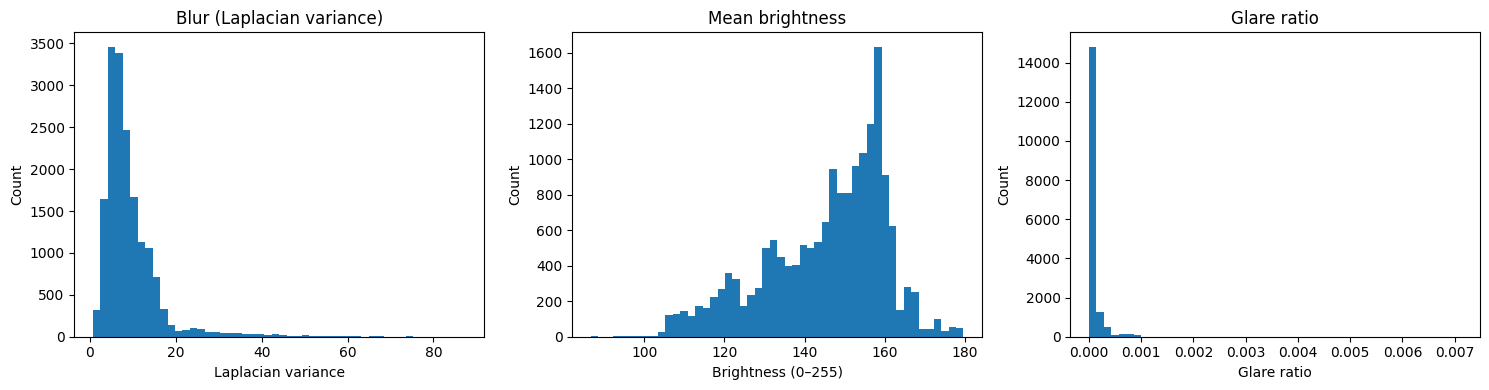

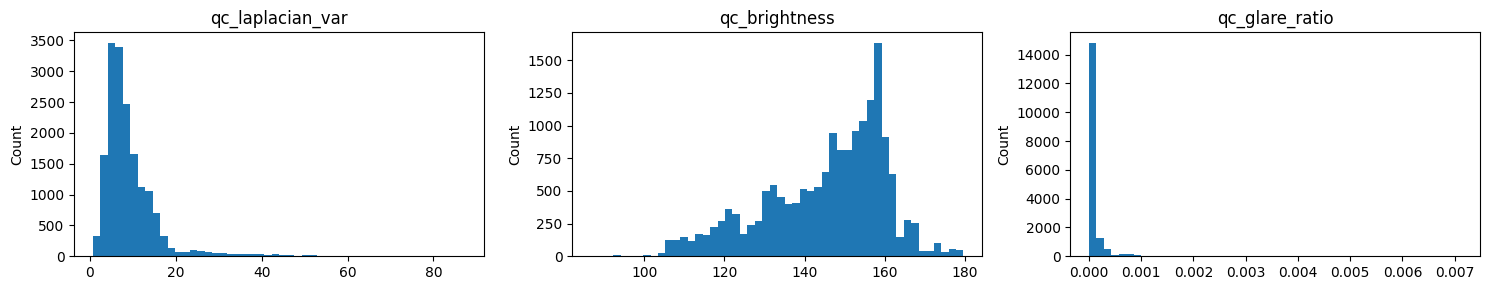


Per-class mean QC stats:


qc_laplacian_var  qc_brightness  qc_glare_ratio
class_canonical                                                   
artistic                  10.486924     141.178402        0.000082
drafted                    9.231701     153.812596        0.000236
merchandise               20.221182     143.293696        0.000123
non_authentic              8.388680     145.662854        0.000051
non_matreskas              8.236901     138.142747        0.000137
political                  5.919300     133.074519        0.000028
religious                  6.665312     140.212811        0.000086
russian_authentic          7.996795     146.547516        0.000046

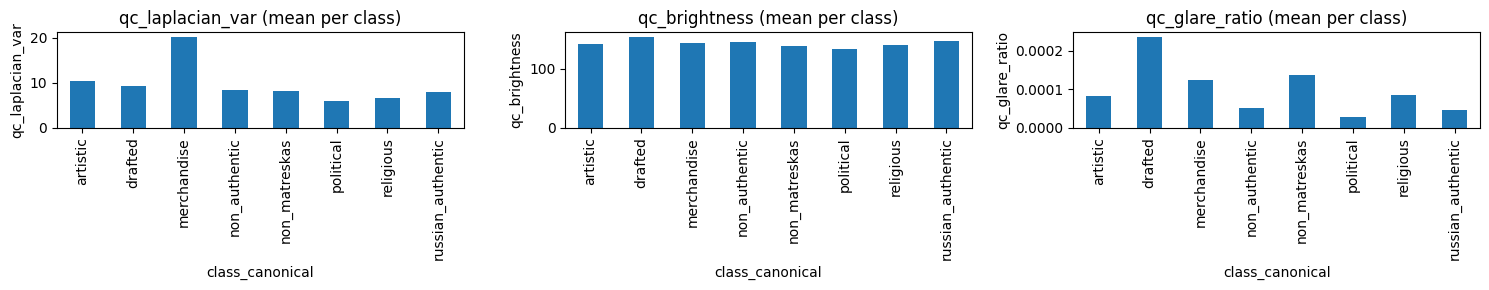

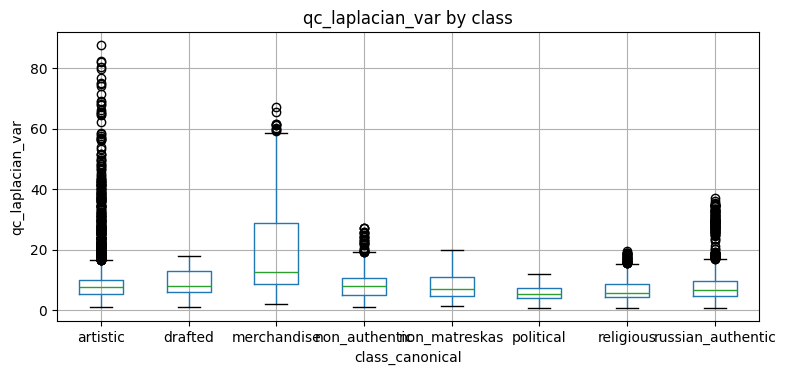

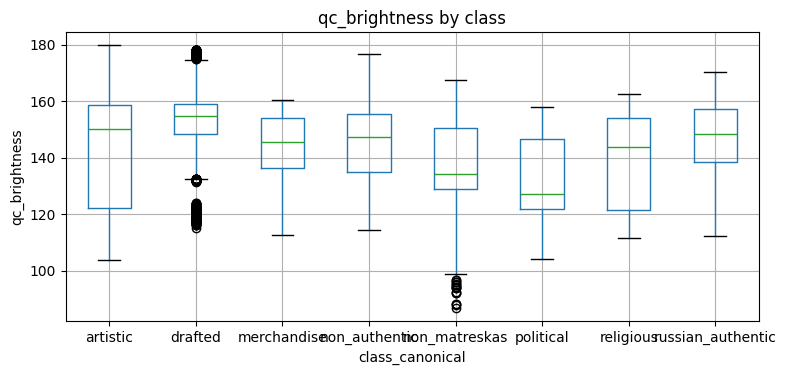

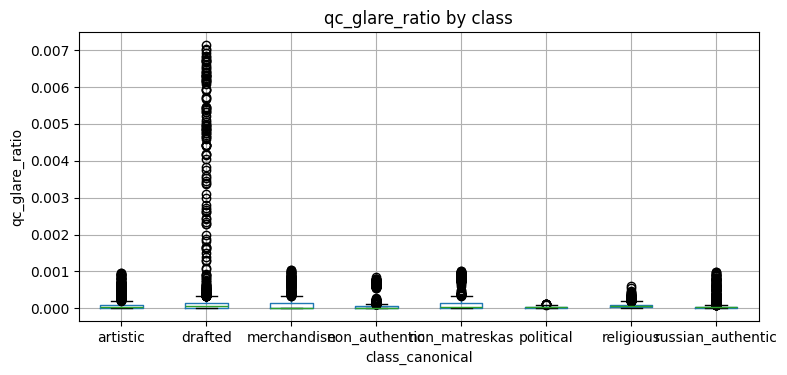

from matplotlib import pyplot as plt
qc_means['qc_laplacian_var'].plot(kind='hist', bins=20, title='qc_laplacian_var')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
qc_means['qc_brightness'].plot(kind='hist', bins=20, title='qc_brightness')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
qc_means['qc_glare_ratio'].plot(kind='hist', bins=20, title='qc_glare_ratio')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
qc_means.plot(kind='scatter', x='qc_laplacian_var', y='qc_brightness', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
qc_means.plot(kind='scatter', x='qc_brightness', y='qc_glare_ratio', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
qc_means['qc_laplacian_var'].plot(kind='line', figsize=(8, 4), title='qc_laplacian_var')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
qc_means['qc_brightness'].plot(kind='line', figsize=(8, 4), title='qc_brightness')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
qc_means['qc_glare_ratio'].plot(kind='line', figsize=(8, 4), title='qc_glare_ratio')
plt.gca().spines[['top', 'right']].set_visible(False)

In [ ]:
# ===========================================
# QC statistics for current Matryoshka VIDEOS
# ===========================================
import os, re
from pathlib import Path

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ---------- PATHS (EDIT HERE IF NEEDED) ----------
# Your screenshot: MyDrive / Matreskas / Videos / Ask Gemini / <class folders>
ROOT = Path("/content/drive/MyDrive/Matreskas/Videos")
OUT_CSV = ROOT.parent / "video_qc_stats.csv2"   # one level up from "Ask Gemini"

# ---------- LABEL MAP / CANONICAL NAMES ----------
ALIASES = {
    "russian_authentic": "russian_authentic",
    "russian authentic": "russian_authentic",
    "russian-authentic": "russian_authentic",
    "russian_auth":      "russian_authentic",

    "non-authentic":     "non_authentic",
    "non authentic":     "non_authentic",
    "non_authentic":     "non_authentic",

    "non-matreskas":     "non_matreskas",
    "non matreskas":     "non_matreskas",
    "non-matreshkas":    "non_matreskas",

    "merchandise":       "merchandise",
    "drafted":           "drafted",
    "artistic":          "artistic",
    "political":         "political",
    "religious":         "religious",
}

def canonize_folder(name: str) -> str:
    key = re.sub(r'[\s\-]+', ' ', name.strip().lower()).replace(" ", "_")
    return ALIASES.get(key, key)

# ---------- QC HELPERS ----------
def laplacian_var(gray):
    return float(cv2.Laplacian(gray, cv2.CV_64F).var())

def mean_brightness(gray):
    return float(gray.mean())

def glare_ratio(bgr):
    hsv = cv2.cvtColor(bgr, cv2.COLOR_BGR2HSV)
    v = hsv[..., 2]
    return float((v > 245).mean())

# ---------- COLLECT STATS ----------
rows = []
exts = {".mp4", ".mov", ".avi", ".mkv", ".MP4", ".MOV", ".AVI", ".MKV"}

print("Scanning videos under:", ROOT)
for class_dir in sorted(ROOT.glob("*")):
    if not class_dir.is_dir():
        continue
    label_raw = class_dir.name
    label_canon = canonize_folder(label_raw)

    for vid_path in sorted(class_dir.rglob("*")):
        if vid_path.suffix not in exts:
            continue

        cap = cv2.VideoCapture(str(vid_path))
        if not cap.isOpened():
            print("[WARN] cannot open:", vid_path)
            continue

        fps = cap.get(cv2.CAP_PROP_FPS) or 30.0
        target_fps = 3.0                     # sample ~3 frames per second
        step = max(int(round(fps / target_fps)), 1)

        print(f"Video: {vid_path.name} | class={label_canon} | fps={fps:.1f} | step={step}")

        frame_index = 0
        grab_index = 0
        while True:
            ret = cap.grab()
            if not ret:
                break
            if grab_index % step == 0:
                ret, bgr = cap.retrieve()
                if not ret:
                    break
                gray = cv2.cvtColor(bgr, cv2.COLOR_BGR2GRAY)

                lv = laplacian_var(gray)
                br = mean_brightness(gray)
                gl = glare_ratio(bgr)

                rows.append({
                    "class_raw": label_raw,
                    "class_canonical": label_canon,
                    "video_path": str(vid_path),
                    "frame_idx": frame_index,
                    "qc_laplacian_var": lv,
                    "qc_brightness": br,
                    "qc_glare_ratio": gl,
                })
                frame_index += 1
            grab_index += 1

        cap.release()

# ---------- BUILD DATAFRAME ----------
df = pd.DataFrame(rows)
print("Total sampled frames:", len(df))
df.to_csv(OUT_CSV, index=False)
print("Saved QC table to:", OUT_CSV)

# ===========================================
# 1) RECREATE YOUR 3-PANEL QC FIGURE
# ===========================================
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].hist(df["qc_laplacian_var"], bins=50)
axes[0].set_title("Blur (Laplacian variance)")
axes[0].set_xlabel("Laplacian variance")
axes[0].set_ylabel("Count")

axes[1].hist(df["qc_brightness"], bins=50)
axes[1].set_title("Mean brightness")
axes[1].set_xlabel("Brightness (0–255)")
axes[1].set_ylabel("Count")

axes[2].hist(df["qc_glare_ratio"], bins=50)
axes[2].set_title("Glare ratio")
axes[2].set_xlabel("Glare ratio")
axes[2].set_ylabel("Count")

plt.tight_layout()
plt.savefig(ROOT.parent / "video_qc_3panel.png", dpi=200)
plt.show()

# ===========================================
# 2) "ALL POSSIBLE STATISTICS"
#    – Global hists + per-class summaries
# ===========================================

qc_cols = ["qc_laplacian_var", "qc_brightness", "qc_glare_ratio"]

# Global histograms in one figure
fig, axes = plt.subplots(1, len(qc_cols), figsize=(5*len(qc_cols), 3))
for ax, col in zip(axes, qc_cols):
    ax.hist(df[col], bins=50)
    ax.set_title(col)
    ax.set_ylabel("Count")
plt.tight_layout()
plt.savefig(ROOT.parent / "video_qc_all_global.png", dpi=200)
plt.show()

# Per-class bar plots for each QC metric (mean)
qc_means = df.groupby("class_canonical")[qc_cols].mean().sort_index()
print("\nPer-class mean QC stats:")
display(qc_means)

fig, axes = plt.subplots(1, len(qc_cols), figsize=(5*len(qc_cols), 3))
for ax, col in zip(axes, qc_cols):
    qc_means[col].plot(kind="bar", ax=ax)
    ax.set_title(f"{col} (mean per class)")
    ax.set_xlabel("class_canonical")
    ax.set_ylabel(col)
plt.tight_layout()
plt.savefig(ROOT.parent / "video_qc_means_per_class.png", dpi=200)
plt.show()

# Optional: boxplots per class for each metric
for col in qc_cols:
    fig, ax = plt.subplots(figsize=(8, 4))
    df.boxplot(column=col, by="class_canonical", ax=ax)
    ax.set_title(f"{col} by class")
    ax.set_xlabel("class_canonical")
    ax.set_ylabel(col)
    plt.suptitle("")
    plt.tight_layout()
    plt.savefig(ROOT.parent / f"video_qc_{col}_by_class.png", dpi=200)
    plt.show()


In [ ]:
import pandas as pd

# Path to your metadata (one row per video or per capture)
meta_path = "/content/matryoshka_metadata.csv"
df = pd.read_csv(meta_path)

# If each row is a video, this directly counts videos per class
counts = df["class_canonical"].value_counts().sort_index()
print(counts)

# If you have multiple rows per video, specify a video ID column, e.g. "video_id"
# and count unique videos per class instead:
# counts = df.groupby("class_canonical")["video_id"].nunique().sort_index()
# print(counts)


In [ ]:
from pathlib import Path
from collections import Counter
import pandas as pd

# Root folder with all video subfolders
ROOT = Path("/content/drive/MyDrive/Matreskas/Videos")

# Video extensions to include
VIDEO_EXTS = {".mov", ".mp4", ".m4v", ".avi", ".MOV", ".MP4"}

# Map folder names to canonical class labels used in your QC plots
CLASS_MAP = {
    "artistic": "artistic",
    "drafted": "drafted",
    "merchandise": "merchandise",
    "non_authentic": "non_authentic",
    "non-matreskas": "non_matreskas",
    "non_matreskas": "non_matreskas",
    "political": "political",
    "religious": "religious",
    "russian_authentic": "russian_authentic",
}

def get_class_from_path(p: Path) -> str:
    """Infer canonical class from the immediate parent folder name."""
    raw = p.parent.name.strip().lower()
    return CLASS_MAP.get(raw, raw)  # falls back to folder name if unknown

counter = Counter()

# Walk all videos under ROOT and count per class
for ext in VIDEO_EXTS:
    for vid in ROOT.rglob(f"*{ext}"):
        cls = get_class_from_path(vid)
        counter[cls] += 1

# Pretty print counts
print("Video counts per class:\n")
for cls in sorted(counter):
    print(f"{cls:16s} {counter[cls]:4d}")

print("\nTotal videos:", sum(counter.values()))

# Optional: make a DataFrame for later plots
df_counts = pd.DataFrame(
    [{"class_canonical": k, "num_videos": v} for k, v in counter.items()]
).sort_values("class_canonical")
print("\nDataFrame:\n", df_counts)


Video counts per class:

artistic           22
drafted            21
merchandise        13
non-authentic      34
non_matreskas      13
political           5
religious          11
russian_authentic   49

Total videos: 168

DataFrame:
      class_canonical  num_videos
1           artistic          22
0            drafted          21
6        merchandise          13
3      non-authentic          34
7      non_matreskas          13
2          political           5
5          religious          11
4  russian_authentic          49


## **Train 2D Diffusion Model**

In [ ]:
# ============================================
# VIDEO → 3D MESH FOR ALL CLASSES (COLMAP v2)
# One representative video per class
# ============================================

print(">>> MULTI-CLASS VIDEO→MESH PIPELINE STARTED <<<")

# 0) Mount Drive + Install dependencies
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import os, shutil, subprocess, json, time
from pathlib import Path
from typing import List, Dict

print("Installing dependencies (ffmpeg, colmap, pyvista)...")
!apt-get -qq update
!apt-get -qq install -y ffmpeg colmap >/dev/null 2>&1
!pip -q install pyvista panel trame pillow

# --- COLMAP executable (from apt) ---
COLMAP_EXE = "colmap"
!$COLMAP_EXE -h > /dev/null
print("✅ COLMAP (apt) available.")

import torch
if torch.cuda.is_available():
    print(f"✅ GPU available: {torch.cuda.get_device_name(0)}")
    print(f"    Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")
else:
    print("⚠️ No GPU detected, will use CPU (slower)")

from PIL import Image, ImageOps
import pyvista as pv

# ======================================================
# 1) CONFIG — ROOTS + CLASS DETECTION
# ======================================================

# Root containing your class folders & videos
ROOT_VIDEOS = Path("/content/drive/MyDrive/Matreskas/Videos")
assert ROOT_VIDEOS.exists(), f"{ROOT_VIDEOS} does not exist"

# Where to put all per-class reconstructions
MESH_ROOT = Path("/content/mesh_output")
MESH_ROOT.mkdir(parents=True, exist_ok=True)

# Temporary frames folder (reused per run)
FRAMES_DIR = Path("/content/video_frames")
VIS_DIR_ROOT = MESH_ROOT / "visualizations"

# Frame extraction settings (you can tweak)
EXTRACT_FPS   = 2            # frames per second from video
MAX_FRAMES    = 120          # safety cap per video
FRAME_QUALITY = 2            # ffmpeg JPEG quality
RESIZE_WIDTH  = 1920         # None = keep original

# COLMAP settings
MAX_IMAGE_SIZE   = 1600
SIFT_MAX_FEATURES = 8000

# Do we render pyvista snapshots for each class?
DO_VISUALIZE = False  # set True if you want the PNGs for every run

# Your 8 classes (2D branch) – we want 1 video for each
CLASSES_8 = [
    "artistic",
    "drafted",
    "merchandise",
    "non_authentic",
    "non_matreskas",
    "political",
    "religious",
    "russian_authentic",
]

# Map various folder substrings → canonical class name
CLASS_ALIASES = {
    "artistic":            "artistic",
    "drafted":             "drafted",
    "merchandise":         "merchandise",
    "non_authentic":       "non_authentic",
    "non-authentic":       "non_authentic",
    "nonauthentic":        "non_authentic",
    "non_matreskas":       "non_matreskas",
    "non-matreskas":       "non_matreskas",
    "non-matreska":        "non_matreskas",
    "nonmatreska":         "non_matreskas",
    "political":           "political",
    "religious":           "religious",
    "russian_authentic":   "russian_authentic",
    "russian-authentic":   "russian_authentic",
    "russian authentic":   "russian_authentic",
}

def log(msg: str):
    print(f"[{time.strftime('%H:%M:%S')}] {msg}", flush=True)

def safe_name(s: str) -> str:
    return "".join(c if c.isalnum() or c in "-_." else "_" for c in s)

def infer_class_from_path(p: Path):
    s = str(p).lower().replace("-", "_")
    for key, label in CLASS_ALIASES.items():
        if key.lower().replace("-", "_") in s:
            return label
    return None

# ======================================================
# 2) FIND ONE VIDEO PER CLASS
# ======================================================

video_exts = {".mp4", ".mov", ".MP4", ".MOV"}
chosen_videos: Dict[str, Path] = {}

log(f"Scanning videos under {ROOT_VIDEOS} ...")
for vid in ROOT_VIDEOS.rglob("*"):
    if vid.suffix not in video_exts:
        continue
    cls = infer_class_from_path(vid)
    if cls is None:
        continue
    if cls in chosen_videos:   # already have one representative video
        continue
    chosen_videos[cls] = vid

log("Chosen representative videos per class:")
for cls in CLASSES_8:
    vp = chosen_videos.get(cls)
    print(f"  {cls:18s} -> {vp.name if vp else 'NONE FOUND'}")

# Filter to only classes where we actually found a video
classes_to_run = [c for c in CLASSES_8 if c in chosen_videos]
if not classes_to_run:
    raise SystemExit("❌ No videos found for any known class – check ROOT_VIDEOS structure.")

# ======================================================
# 3) SHELL HELPER
# ======================================================

def run(cmd, cwd=None, check=True, show_output=False):
    if isinstance(cmd, str):
        cmd = cmd.split()

    if cmd[0] == "colmap":
        cmd[0] = COLMAP_EXE

    log("RUN: " + " ".join(cmd))

    env = os.environ.copy()
    env["QT_QPA_PLATFORM"] = "offscreen"
    env["DISPLAY"] = ""

    p = subprocess.run(cmd, cwd=cwd, text=True, capture_output=True, env=env)

    if p.stdout.strip():
        if show_output:
            print(p.stdout)
        else:
            for line in p.stdout.split("\n"):
                if any(k in line.lower() for k in ["error", "warning", "elapsed", "registered", "points", "images", "frame="]):
                    print("  →", line)

    if p.returncode and p.stderr.strip():
        print("STDERR:\n" + p.stderr[:2000])

    if check and p.returncode != 0:
        raise RuntimeError(f"Command failed with exit code {p.returncode}")

    return p.returncode == 0

# ======================================================
# 4) FRAME EXTRACTION (per video)
# ======================================================

def extract_frames_from_video(video_path: Path, output_dir: Path):
    log(f"📹 Extracting frames from: {video_path.name}")

    if output_dir.exists():
        shutil.rmtree(output_dir)
    output_dir.mkdir(parents=True)

    # Probe for duration
    probe_cmd = [
        "ffprobe", "-v", "error",
        "-select_streams", "v:0",
        "-count_packets", "-show_entries",
        "stream=nb_read_packets,r_frame_rate,duration",
        "-of", "json", str(video_path)
    ]
    probe = subprocess.run(probe_cmd, capture_output=True, text=True)
    if probe.returncode == 0:
        try:
            info = json.loads(probe.stdout)
            if info.get("streams"):
                stream = info["streams"][0]
                duration = float(stream.get("duration", 0))
                log(f"  Duration: {duration:.1f}s → ~{int(duration * EXTRACT_FPS)} frames at {EXTRACT_FPS} fps")
        except Exception:
            pass

    ffmpeg_cmd = [
        "ffmpeg",
        "-i", str(video_path),
        "-q:v", str(FRAME_QUALITY),
        "-frames:v", str(MAX_FRAMES),
        "-start_number", "0",
    ]

    filters = [f"fps={EXTRACT_FPS}"]
    if RESIZE_WIDTH:
        filters.append(f"scale={RESIZE_WIDTH}:-1")

    ffmpeg_cmd.extend(["-vf", ",".join(filters)])
    ffmpeg_cmd.append(str(output_dir / "frame_%04d.jpg"))

    if not run(ffmpeg_cmd, show_output=False):
        raise RuntimeError("Frame extraction failed")

    frames = sorted(output_dir.glob("*.jpg"))
    log(f"✅ Extracted {len(frames)} frames")

    if frames:
        sample = Image.open(frames[0])
        log(f"  Frame size: {sample.size[0]}x{sample.size[1]}")

    return frames

# ======================================================
# 5) COLMAP RECONSTRUCTION (per video)
# ======================================================

def run_colmap_reconstruction(frames_dir: Path, output_dir: Path):
    log(f"🚀 Starting COLMAP reconstruction in {output_dir}")
    sparse_dir = output_dir / "sparse"
    dense_dir  = output_dir / "dense"
    db_path    = output_dir / "database.db"

    for d in [sparse_dir, dense_dir]:
        d.mkdir(parents=True, exist_ok=True)

    # Step 1: Feature extraction (CPU)
    log("Step 1/7: Feature extraction")
    if not run([
        "colmap", "feature_extractor",
        "--database_path", str(db_path),
        "--image_path", str(frames_dir),
        "--SiftExtraction.use_gpu", "0",
        "--SiftExtraction.max_num_features", str(SIFT_MAX_FEATURES),
        "--ImageReader.single_camera", "1",
        "--ImageReader.camera_model", "SIMPLE_PINHOLE",
    ]):
        raise RuntimeError("Feature extraction failed")

    # Step 2: Feature matching (CPU)
    log("Step 2/7: Feature matching (sequential, no loop detection)")
    success = run([
        "colmap", "sequential_matcher",
        "--database_path", str(db_path),
        "--SiftMatching.use_gpu", "0",
        "--SequentialMatching.overlap", "20",
        "--SequentialMatching.loop_detection", "0",
    ], check=False)
    if not success:
        log("Sequential matching failed – trying exhaustive.")
        if not run([
            "colmap", "exhaustive_matcher",
            "--database_path", str(db_path),
            "--SiftMatching.use_gpu", "0",
            "--SiftMatching.num_threads", "8",
        ]):
            raise RuntimeError("Feature matching failed")

    # Step 3: Sparse reconstruction
    log("Step 3/7: Sparse mapper")
    if not run([
        "colmap", "mapper",
        "--database_path", str(db_path),
        "--image_path", str(frames_dir),
        "--output_path", str(sparse_dir),
        "--Mapper.num_threads", "8",
        "--Mapper.init_min_num_inliers", "100",
        "--Mapper.init_max_error", "4",
    ]):
        raise RuntimeError("Sparse reconstruction failed")

    models = [d for d in sparse_dir.iterdir() if d.is_dir() and any(d.iterdir())]
    if not models:
        raise RuntimeError("No sparse model generated")
    model_dir = models[0]
    log(f"  Using sparse model: {model_dir.name}")

    # Export sparse.ply
    sparse_ply = output_dir / "sparse.ply"
    log("  Exporting sparse PLY")
    run([
        "colmap", "model_converter",
        "--input_path", str(model_dir),
        "--output_path", str(sparse_ply),
        "--output_type", "PLY",
    ], check=False)

    # Step 4: Image undistortion
    log("Step 4/7: Image undistortion")
    if not run([
        "colmap", "image_undistorter",
        "--image_path", str(frames_dir),
        "--input_path", str(model_dir),
        "--output_path", str(dense_dir),
        "--output_type", "COLMAP",
        "--max_image_size", str(MAX_IMAGE_SIZE),
    ]):
        raise RuntimeError("Image undistortion failed")

    # Step 5: Dense stereo
    log("Step 5/7: Dense stereo")
    run([
        "colmap", "patch_match_stereo",
        "--workspace_path", str(dense_dir),
        "--workspace_format", "COLMAP",
        "--PatchMatchStereo.geom_consistency", "1",
        "--PatchMatchStereo.num_samples", "15",
        "--PatchMatchStereo.num_iterations", "5",
    ], check=False)

    # Step 6: Stereo fusion
    log("Step 6/7: Stereo fusion")
    dense_ply = dense_dir / "fused.ply"
    has_dense = run([
        "colmap", "stereo_fusion",
        "--workspace_path", str(dense_dir),
        "--workspace_format", "COLMAP",
        "--input_type", "geometric",
        "--output_path", str(dense_ply),
        "--StereoFusion.min_num_pixels", "3",
    ], check=False)

    if has_dense and dense_ply.exists() and dense_ply.stat().st_size > 10000:
        log("✅ Dense point cloud created")
    else:
        log("⚠️ Dense fusion failed or small – continuing with sparse only")

    # Step 7: Mesh creation attempts
    log("Step 7/7: Mesh creation (Poisson / Delaunay)")
    final_mesh_path = None

    if has_dense and dense_ply.exists() and dense_ply.stat().st_size > 10000:
        poisson_path = output_dir / "mesh_poisson.ply"
        if run([
            "colmap", "poisson_mesher",
            "--input_path", str(dense_ply),
            "--output_path", str(poisson_path),
            "--PoissonMesher.depth", "10",
            "--PoissonMesher.trim", "7",
        ], check=False):
            log("✅ Poisson mesh generated")
            final_mesh_path = poisson_path

        delaunay_path = output_dir / "mesh_delaunay.ply"
        if run([
            "colmap", "delaunay_mesher",
            "--input_path", str(dense_dir),
            "--output_path", str(delaunay_path),
        ], check=False):
            log("✅ Delaunay mesh generated")
            if final_mesh_path is None:
                final_mesh_path = delaunay_path
    else:
        log("No valid dense.ply for meshing – using sparse only if available.")

    if final_mesh_path is None and sparse_ply.exists():
        final_mesh_path = sparse_ply
        log("ℹ️ Falling back to sparse.ply as final mesh/point cloud.")

    if final_mesh_path is None:
        log("⚠️ No PLY file (sparse or dense) found.")
    return sparse_ply, final_mesh_path

# ======================================================
# 6) VISUALIZATION (optional, per run)
# ======================================================

def visualize_mesh(mesh_path: Path, vis_dir: Path):
    if not mesh_path or not mesh_path.exists():
        log("No mesh file to visualize.")
        return

    vis_dir.mkdir(parents=True, exist_ok=True)
    pv.set_plot_theme("document")
    plotter = pv.Plotter(off_screen=True, window_size=[600, 600])

    mesh = pv.read(mesh_path)
    plotter.add_mesh(mesh, color="white", smooth_shading=True, specular=1.0)
    plotter.camera.zoom(1.2)

    image_paths = []
    # Front
    plotter.camera_position = "xy"
    plotter.camera.elevation = 0
    img = vis_dir / "01_front.png"
    plotter.screenshot(img); image_paths.append(img)
    # Side
    plotter.camera.azimuth = 90
    img = vis_dir / "02_side.png"
    plotter.screenshot(img); image_paths.append(img)
    # Other side
    plotter.camera.azimuth = 270
    img = vis_dir / "03_side_other.png"
    plotter.screenshot(img); image_paths.append(img)
    # Top
    plotter.camera_position = "xz"
    plotter.camera.elevation = 0
    img = vis_dir / "04_top.png"
    plotter.screenshot(img); image_paths.append(img)

    plotter.close()
    log(f"📸 Saved {len(image_paths)} snapshots to {vis_dir}")

# ======================================================
# 7) MAIN LOOP — RUN PIPELINE FOR EACH CLASS
# ======================================================

summary = []

for cls in classes_to_run:
    video_path = chosen_videos[cls]
    run_tag = f"{cls}__{safe_name(video_path.stem)}"
    out_root = MESH_ROOT / run_tag
    vis_dir = VIS_DIR_ROOT / run_tag

    print("\n" + "="*72)
    print(f"CLASS: {cls}  VIDEO: {video_path.name}")
    print(f"OUTPUT DIR: {out_root}")
    print("="*72)

    out_root.mkdir(parents=True, exist_ok=True)

    try:
        # 1) Extract frames
        frames = extract_frames_from_video(video_path, FRAMES_DIR)
        if len(frames) < 10:
            raise RuntimeError(f"Too few frames extracted ({len(frames)}). Need at least 10.")

        # 2) Run COLMAP
        sparse_ply, final_mesh = run_colmap_reconstruction(FRAMES_DIR, out_root)

        # 3) Save small summary.json
        with open(out_root / "summary.json", "w") as f:
            json.dump({
                "class_8": cls,
                "video": str(video_path),
                "frames_extracted": len(frames),
                "sparse_ply": str(sparse_ply) if sparse_ply and sparse_ply.exists() else None,
                "final_mesh": str(final_mesh) if final_mesh and final_mesh.exists() else None,
            }, f, indent=2)

        # 4) Optional visualization
        if DO_VISUALIZE and final_mesh and final_mesh.exists():
            visualize_mesh(final_mesh, vis_dir)

        summary.append({
            "class_8": cls,
            "video": str(video_path),
            "out_root": str(out_root),
            "final_mesh": str(final_mesh) if final_mesh and final_mesh.exists() else None,
        })

    except Exception as e:
        print(f"❌ Failed for class {cls} / video {video_path.name}: {e}")
        import traceback; traceback.print_exc()
    finally:
        # Clean temp frames to save space
        if FRAMES_DIR.exists():
            frame_count = len(list(FRAMES_DIR.glob("*")))
            if frame_count > 0:
                log(f"Cleaning up {frame_count} temporary frames...")
                shutil.rmtree(FRAMES_DIR, ignore_errors=True)

# Print global summary
print("\n" + "="*72)
print("MULTI-CLASS VIDEO→MESH SUMMARY:")
for row in summary:
    print(f"- {row['class_8']:18s} | video={Path(row['video']).name:20s} "
          f"| out={row['out_root']} "
          f"| final_mesh={row['final_mesh']}")
print("="*72)
print(">>> MULTI-CLASS VIDEO→MESH PIPELINE FINISHED <<<")


>>> MULTI-CLASS VIDEO→MESH PIPELINE STARTED <<<
Mounted at /content/drive
Installing dependencies (ffmpeg, colmap, pyvista)...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 106.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.1/245.1 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.2/44.2 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.3/112.3 MB 22.9 MB/s eta 0:00:00
✅ COLMAP (apt) available.
✅ GPU available: NVIDIA A100-SXM4-40GB
    Memory: 39.6 GB
[11:37:21] Scanning videos under /content/drive/MyDrive/Matreskas/Videos ...
[11:37:23] Chosen representative videos per class:
  artistic           -> IMG_4783.MOV
  drafted            -> IMG_5097.mov
  merchandise        -> IMG_5212.MOV
  non_authentic      -> IMG_5095.MOV
  non

In [ ]:
# ============================================================
# Grid of Meshes (Sparse + Dense) with PyVista
#
# - Scans /content/mesh_output for subfolders containing sparse.ply
# - Optionally overlays dense.ply if present
# - Normalizes each mesh (center + scale)
# - Renders them in a grid and saves a screenshot
# ============================================================

import os
import math
from pathlib import Path

import numpy as np
import pyvista as pv

# -------------------------
# 0) CONFIG
# -------------------------
ROOT = Path("/content/mesh_output")   # root folder with all mesh subfolders
SPARSE_NAME = "sparse.ply"
DENSE_NAME = "dense.ply"
MAX_MODELS = 12                       # limit how many subfolders to show in grid
OUT_IMAGE = ROOT / "mesh_grid.png"    # output screenshot

# -------------------------
# 1) PyVista off-screen setup (Colab-friendly)
# -------------------------
try:
    pv.start_xvfb()  # safe to ignore if not available
except Exception:
    pass

# -------------------------
# 2) Helpers
# -------------------------
def find_mesh_cases(root: Path):
    """
    Return a list of (label, sparse_path, dense_path_or_None)
    for each subfolder that has at least sparse.ply.
    """
    cases = []
    for sub in sorted(root.iterdir()):
        if not sub.is_dir():
            continue

        sparse_path = sub / SPARSE_NAME
        if not sparse_path.exists():
            continue

        dense_path = sub / DENSE_NAME
        label = sub.name  # use folder name as label
        cases.append((label, sparse_path, dense_path if dense_path.exists() else None))

    return cases


def load_and_normalize_mesh(ply_path: Path):
    """
    Load a mesh/point cloud with PyVista and:
      - center it at the origin
      - scale it to roughly unit size
    """
    mesh = pv.read(ply_path)

    # Center at origin
    center = np.array(mesh.center, dtype=float)
    mesh.translate(-center, inplace=True)

    # Uniform scale so largest dimension ~ 1
    xmin, xmax, ymin, ymax, zmin, zmax = mesh.bounds
    size = max(xmax - xmin, ymax - ymin, zmax - zmin)
    if size > 0:
        mesh.scale(1.0 / size, inplace=True)

    return mesh

# -------------------------
# 3) Discover mesh cases
# -------------------------
cases = find_mesh_cases(ROOT)
if not cases:
    raise SystemExit(f"No subfolders with {SPARSE_NAME} found in {ROOT}")

# Optionally limit how many we show
cases = cases[:MAX_MODELS]
print(f"Found {len(cases)} mesh cases:")
for label, sp, dp in cases:
    print("  -", label, "sparse:", sp, "dense:", dp)

# -------------------------
# 4) Prepare grid layout
# -------------------------
n = len(cases)
cols = min(4, n)                  # up to 4 columns
rows = math.ceil(n / cols)

print(f"\nCreating grid with {rows} rows × {cols} cols")

plotter = pv.Plotter(shape=(rows, cols), window_size=(1600, 1200), off_screen=True)
plotter.set_background("white")

# -------------------------
# 5) Add each mesh to its subplot
# -------------------------
for idx, (label, sparse_path, dense_path) in enumerate(cases):
    r = idx // cols
    c = idx % cols
    plotter.subplot(r, c)

    print(f"Rendering {label} in cell ({r}, {c})")

    # Load & normalize sparse
    sparse_mesh = load_and_normalize_mesh(sparse_path)

    # Add sparse (e.g., thicker / more visible)
    plotter.add_mesh(
        sparse_mesh,
        color=None,                    # let PyVista choose default
        point_size=5,
        render_points_as_spheres=True,
        opacity=1.0,
        name=f"{label}_sparse",
        show_edges=False,
    )

    # If dense exists, overlay as more transparent
    if dense_path is not None:
        dense_mesh = load_and_normalize_mesh(dense_path)
        plotter.add_mesh(
            dense_mesh,
            color=None,
            point_size=3,
            render_points_as_spheres=True,
            opacity=0.4,
            name=f"{label}_dense",
            show_edges=False,
        )

    # Set a nice isometric camera & add a label
    plotter.view_isometric()
    plotter.add_text(label, font_size=10)

# Link views so all subplots share camera
plotter.link_views()

# -------------------------
# 6) Render and save screenshot
# -------------------------
print("\nRendering grid and saving screenshot...")
plotter.show(screenshot=str(OUT_IMAGE))
print(f"✅ Saved mesh grid to: {OUT_IMAGE}")


/usr/local/lib/python3.12/dist-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


Found 8 mesh cases:
  - artistic__IMG_4783 sparse: /content/mesh_output/artistic__IMG_4783/sparse.ply dense: None
  - drafted__IMG_5097 sparse: /content/mesh_output/drafted__IMG_5097/sparse.ply dense: None
  - merchandise__IMG_5212 sparse: /content/mesh_output/merchandise__IMG_5212/sparse.ply dense: None
  - non_authentic__IMG_5095 sparse: /content/mesh_output/non_authentic__IMG_5095/sparse.ply dense: None
  - non_matreskas__IMG_5132 sparse: /content/mesh_output/non_matreskas__IMG_5132/sparse.ply dense: None
  - political__IMG_4799 sparse: /content/mesh_output/political__IMG_4799/sparse.ply dense: None
  - religious__IMG_4792 sparse: /content/mesh_output/religious__IMG_4792/sparse.ply dense: None
  - russian_authentic__IMG_4787 sparse: /content/mesh_output/russian_authentic__IMG_4787/sparse.ply dense: None

Creating grid with 2 rows × 4 cols
Rendering artistic__IMG_4783 in cell (0, 0)
Rendering drafted__IMG_5097 in cell (0, 1)
Rendering merchandise__IMG_5212 in cell (0, 2)
Rendering no

In [ ]:
# ============================================
# Matryoshka: Video → SfM sparse → Poisson mesh
#           → Real vs Mesh grid (8 dolls)
# CPU-only COLMAP (no OpenGL/CUDA)
# ============================================

import os, subprocess, shutil
from pathlib import Path

import numpy as np
import open3d as o3d
import matplotlib.pyplot as plt

from google.colab import drive

# ---------- 0) Mount Drive & basic setup ----------
drive.mount('/content/drive', force_remount=True)

ROOT_VIDEOS = Path("/content/drive/MyDrive/Matreskas/Videos")
WORK_ROOT = Path("/content/matryoshka_from_videos")
WORK_ROOT.mkdir(parents=True, exist_ok=True)

# Your 8 exact videos
VIDEO_CONFIG = [
    ("Artistic",         ROOT_VIDEOS / "Artistic"         / "IMG_4783.MOV"),
    ("Drafted",          ROOT_VIDEOS / "Drafted"          / "IMG_5289.MOV"),
    ("Merchandise",      ROOT_VIDEOS / "Merchandise"      / "IMG_5221.MOV"),
    ("Non-authentic",    ROOT_VIDEOS / "Non-authentic"    / "IMG_5298.MOV"),
    ("Non-Matreskas",    ROOT_VIDEOS / "Non-Matreskas"    / "IMG_5132.MOV"),
    ("Political",        ROOT_VIDEOS / "Political"        / "IMG_4799.MOV"),
    ("Religious",        ROOT_VIDEOS / "Religious"        / "IMG_4792.MOV"),
    ("Russian_Authentic",ROOT_VIDEOS / "Russian_Authentic"/ "IMG_5367.MOV"),
]

# ---------- 1) Helper: run shell command (CPU-only, headless Qt) ----------

def run_cmd(cmd, cwd=None):
    """
    Run a shell command, print stdout, and raise on error.
    Forces Qt to use 'offscreen' so COLMAP does not try xcb,
    and we will *also* explicitly request CPU SIFT.
    """
    print("\n>>>", " ".join(map(str, cmd)))
    env = os.environ.copy()
    env["QT_QPA_PLATFORM"] = "offscreen"   # avoid xcb GUI
    proc = subprocess.run(
        cmd,
        cwd=cwd,
        env=env,
        text=True,
        stdout=subprocess.PIPE,
        stderr=subprocess.PIPE,
    )
    print(proc.stdout)
    if proc.returncode != 0:
        print("=== STDERR ===")
        print(proc.stderr)
        raise subprocess.CalledProcessError(proc.returncode, cmd)
    return proc

# ---------- 2) Extract frames + preview per video ----------

def ensure_frames_and_preview(workspace: Path, video_path: Path, fps: int = 2):
    """
    - Extract frames with ffmpeg if not already present.
    - Use the first frame as preview.jpg.
    """
    images_dir = workspace / "images"
    images_dir.mkdir(parents=True, exist_ok=True)

    # If no frames yet, extract
    if not any(images_dir.glob("frame_*.jpg")):
        run_cmd([
            "ffmpeg", "-y",
            "-i", str(video_path),
            "-vf", f"fps={fps}",
            str(images_dir / "frame_%04d.jpg")
        ])

    preview = workspace / "preview.jpg"
    if not preview.exists():
        frames = sorted(images_dir.glob("frame_*.jpg"))
        if not frames:
            raise RuntimeError(f"No frames extracted in {images_dir}")
        shutil.copy(frames[0], preview)

    return images_dir, preview

# ---------- 3) COLMAP sparse SfM (CPU-only SIFT) ----------

def run_colmap_sparse(workspace: Path):
    """
    - feature_extractor (CPU SIFT)
    - exhaustive_matcher (CPU SIFT matcher)
    - mapper → sparse model
    Returns: path to sparse model directory (usually workspace/sparse/0)
    """
    images_dir = workspace / "images"
    db_path = workspace / "database.db"
    sparse_dir = workspace / "sparse"
    sparse_dir.mkdir(exist_ok=True)

    # 3.1 Feature extraction (CPU)
    if not db_path.exists():
        run_cmd([
            "colmap", "feature_extractor",
            "--database_path", str(db_path),
            "--image_path", str(images_dir),
            "--ImageReader.single_camera", "1",
            "--ImageReader.camera_model", "SIMPLE_RADIAL",
            "--SiftExtraction.use_gpu", "0"
        ])
    else:
        print(f"Using existing database: {db_path}")

    # 3.2 Exhaustive matcher (CPU)
    run_cmd([
        "colmap", "exhaustive_matcher",
        "--database_path", str(db_path),
        "--SiftMatching.use_gpu", "0"
    ])

    # 3.3 Mapper (build sparse SfM model)
    run_cmd([
        "colmap", "mapper",
        "--database_path", str(db_path),
        "--image_path", str(images_dir),
        "--output_path", str(sparse_dir)
    ])

    # Choose model dir: prefer "0" if present, otherwise first
    model_dir = sparse_dir / "0"
    if not model_dir.exists():
        model_candidates = [d for d in sparse_dir.iterdir() if d.is_dir()]
        if not model_candidates:
            raise RuntimeError(f"No sparse models created in {sparse_dir}")
        model_dir = sorted(model_candidates)[0]

    print(f"Using sparse model: {model_dir}")
    return model_dir

# ---------- 4) Export sparse model to PLY ----------

def export_sparse_to_ply(workspace: Path, model_dir: Path):
    """
    Use COLMAP's model_converter to get a sparse point cloud in PLY format.
    """
    sparse_ply = workspace / "sparse.ply"
    run_cmd([
        "colmap", "model_converter",
        "--input_path", str(model_dir),
        "--output_path", str(sarse_ply := sparse_ply),
        "--output_type", "PLY",
    ])
    if not sparse_ply.exists():
        raise RuntimeError(f"model_converter did not create {sparse_ply}")
    return sparse_ply

# ---------- 5) Poisson mesh from sparse point cloud ----------

def build_mesh_from_sparse(sparse_ply: Path, mesh_out: Path):
    """
    - Load sparse.ply as Open3D point cloud.
    - Normalize (center).
    - Estimate normals.
    - Poisson-reconstruct a surface.
    - Crop with the sparse cloud bounding box.
    - Clean and save mesh.
    Returns: Open3D TriangleMesh
    """
    print(f"\nLoading sparse cloud: {sparse_ply}")
    pcd = o3d.io.read_point_cloud(str(sparse_ply))
    if pcd.is_empty():
        raise RuntimeError(f"Empty point cloud in {sparse_ply}")

    # Normalize: center to origin
    bbox = pcd.get_axis_aligned_bounding_box()
    center = bbox.get_center()
    pcd.translate(-center)

    print("Estimating normals...")
    pcd.estimate_normals(
        search_param=o3d.geometry.KDTreeSearchParamHybrid(
            radius=0.05, max_nn=50
        )
    )
    pcd.normalize_normals()

    print("Running Poisson reconstruction...")
    mesh, densities = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(
        pcd, depth=9
    )

    # Crop mesh to the bounding box of original points (also centered)
    crop_bbox = pcd.get_axis_aligned_bounding_box()
    mesh = mesh.crop(crop_bbox)

    print("Cleaning mesh...")
    mesh.remove_degenerate_triangles()
    mesh.remove_duplicated_triangles()
    mesh.remove_duplicated_vertices()
    mesh.remove_non_manifold_edges()
    mesh.compute_vertex_normals()

    o3d.io.write_triangle_mesh(str(mesh_out), mesh)
    print(f"Saved mesh: {mesh_out}")
    return mesh

# ---------- 6) Offscreen render of mesh into PNG ----------

def render_mesh_png(mesh, out_path: Path, width: int = 512, height: int = 512):
    """
    Use Open3D's OffscreenRenderer to render a mesh to PNG.
    """
    print(f"Rendering mesh to {out_path} ...")
    bbox = mesh.get_axis_aligned_bounding_box()
    center = bbox.get_center()
    extent = bbox.get_extent()
    radius = np.linalg.norm(extent) * 1.2

    renderer = o3d.visualization.rendering.OffscreenRenderer(width, height)

    mat = o3d.visualization.rendering.MaterialRecord()
    mat.shader = "defaultLit"
    renderer.scene.add_geometry("mesh", mesh, mat)

    eye = center + np.array([0.0, 0.0, radius])
    up = np.array([0.0, 1.0, 0.0])
    renderer.setup_camera(60.0, center, eye, up)
    renderer.scene.set_background(np.array([1.0, 1.0, 1.0, 1.0]))

    img = renderer.render_to_image()
    o3d.io.write_image(str(out_path), img)

    renderer.scene.clear_geometry()
    del renderer

# ---------- 7) Main loop over 8 videos ----------

results = []  # (label, preview_path, mesh_png_path)

for label, video_path in VIDEO_CONFIG:
    workspace = WORK_ROOT / f"{label}__{video_path.stem}"
    workspace.mkdir(parents=True, exist_ok=True)

    print("\n" + "="*80)
    print(f"Processing {label}: {video_path}")
    print(f"Workspace: {workspace}")
    print("="*80)

    # 1) Frames + preview
    images_dir, preview = ensure_frames_and_preview(workspace, video_path)

    # 2) COLMAP sparse (CPU, no OpenGL)
    model_dir = run_colmap_sparse(workspace)

    # 3) Export sparse.ply
    sparse_ply = export_sparse_to_ply(workspace, model_dir)

    # 4) Poisson mesh
    mesh_path = workspace / "mesh_poisson.ply"
    mesh = build_mesh_from_sparse(sparse_ply, mesh_path)

    # 5) Render mesh to PNG
    mesh_png = workspace / "mesh_view.png"
    render_mesh_png(mesh, mesh_png)

    results.append((label, preview, mesh_png))

# ---------- 8) Real vs Mesh grid ----------

n = len(results)
fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(6, 3*n))

if n == 1:
    axes = np.array([axes])

for row, (label, preview, mesh_png) in enumerate(results):
    ax_real = axes[row, 0]
    ax_mesh = axes[row, 1]

    ax_real.imshow(plt.imread(str(preview)))
    ax_real.set_title(f"{label} – real", fontsize=10)
    ax_real.axis("off")

    ax_mesh.imshow(plt.imread(str(mesh_png)))
    ax_mesh.set_title(f"{label} – mesh", fontsize=10)
    ax_mesh.axis("off")

plt.tight_layout()
grid_path = WORK_ROOT / "real_vs_mesh_grid.png"
plt.savefig(grid_path, dpi=200)
print(f"\n✅ Saved grid: {grid_path}")
plt.show()


Streaming output truncated to the last 5000 lines.
Registering image #2 (10)

  => Image sees 2176 / 3803 points

Pose refinement report
----------------------
    Residuals : 4400
   Parameters : 6
   Iterations : 6
         Time : 0.0205719 [s]
 Initial cost : 0.473197 [px]
   Final cost : 0.470299 [px]
  Termination : Convergence

  => Continued observations: 2169
  => Added observations: 847

Bundle adjustment report
------------------------
    Residuals : 46916
   Parameters : 10427
   Iterations : 22
         Time : 0.421138 [s]
 Initial cost : 0.383436 [px]
   Final cost : 0.367084 [px]
  Termination : Convergence

  => Merged observations: 174
  => Completed observations: 87
  => Filtered observations: 68
  => Changed observations: 0.012590

Bundle adjustment report
------------------------
    Residuals : 47034
   Parameters : 10391
   Iterations : 3
         Time : 0.071816 [s]
 Initial cost : 0.433952 [px]
   Final cost : 0.428351 [px]
  Termination : Convergence

  => Merg

Cell 1 — 2D silhouettes, single-color, overlapped nesting

Mounted at /content/drive
Selected political set_ids (dolls):
   political__IMG_4799
   political__IMG_4802
   political__IMG_4803
   political__IMG_4804
   political__IMG_4805

Representative political frames:
                    set_id                                         frame_path  \
17951  political__IMG_4799  /content/drive/MyDrive/Matreskas/matryoshka_sm...   
18112  political__IMG_4802  /content/drive/MyDrive/Matreskas/matryoshka_sm...   
18272  political__IMG_4803  /content/drive/MyDrive/Matreskas/matryoshka_sm...   
18425  political__IMG_4804  /content/drive/MyDrive/Matreskas/matryoshka_sm...   
18579  political__IMG_4805  /content/drive/MyDrive/Matreskas/matryoshka_sm...   

       frame_idx  
17951         77  
18112         83  
18272         77  
18425         76  
18579         77  


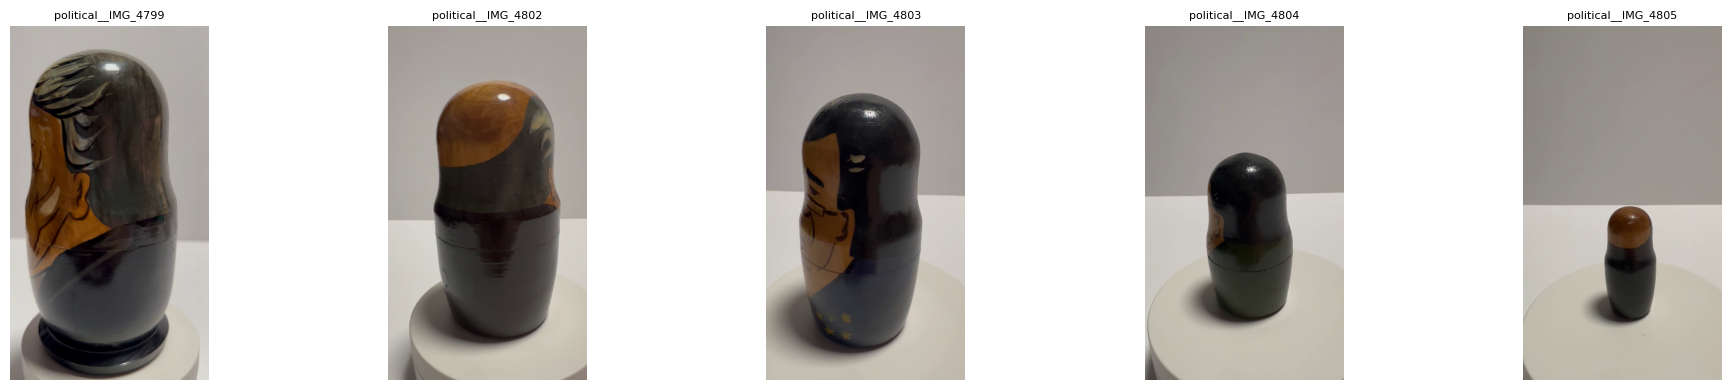

Saved original grid to: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_2d/political_originals.png
Saved raw full silhouette: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_2d/political__IMG_4799_silhouette_full.png
Saved raw full silhouette: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_2d/political__IMG_4802_silhouette_full.png
Saved raw full silhouette: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_2d/political__IMG_4803_silhouette_full.png
Saved raw full silhouette: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_2d/political__IMG_4804_silhouette_full.png
Saved raw full silhouette: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_2d/political__IMG_4805_silhouette_full.png
Saved single nested silhouette: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_2d/00_political__IMG_4799_nested_single.pn

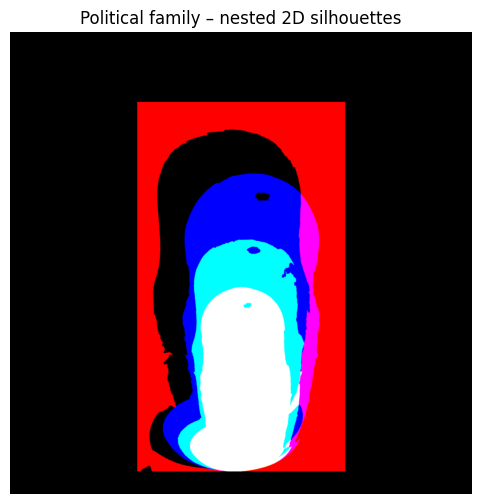

Overlapped nested silhouettes saved to: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_2d/political_nested_overlap.png


In [ ]:
# ============================================
# CELL 1 — 2D POLITICAL FAMILY:
# - Load frames for political dolls
# - Extract silhouettes
# - Make single-color per doll
# - Nest and overlap (smaller inside bigger)
# ============================================

!pip install -q opencv-python-headless matplotlib pandas

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ------------ CONFIG ------------
# Use the PROJECT path printed by your previous run
PROJECT = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015")
META_CSV = PROJECT / "metadata.csv"

OUT_2D_DIR = PROJECT / "political_2d"
OUT_2D_DIR.mkdir(parents=True, exist_ok=True)

FOLDER_CANONICAL = "political"
MAX_DOLLS = 5  # up to 5 political dolls

# target canvas for nesting
CANVAS_W = 1024
CANVAS_H = 1024

INNER_FRACTION = 0.85  # fraction of outer height/width as inner cavity
CLEARANCE = 0.95       # additional shrinkage so inner fits inside

# colors: BGR (OpenCV) for up to 5 dolls
COLOR_TABLE = [
    (0,   0, 255),  # red
    (0, 255,   0),  # green
    (255, 0,   0),  # blue
    (0, 255, 255),  # yellow
    (255, 0, 255),  # magenta
]

# ------------ 1) Load metadata & pick representative frames ------------
meta = pd.read_csv(META_CSV)

# filter for political canonical folder
pol = meta[meta["folder_canonical"] == FOLDER_CANONICAL].copy()
assert not pol.empty, "No political frames found in metadata.csv"

# one doll (set_id) = one physical political matryoshka
# pick up to MAX_DOLLS different set_ids
set_ids = pol["set_id"].unique().tolist()
set_ids = set_ids[:MAX_DOLLS]

print("Selected political set_ids (dolls):")
for sid in set_ids:
    print("  ", sid)

def pick_representative_frame(df_group):
    # pick approx middle frame of that video set
    df_group = df_group.sort_values("frame_idx")
    return df_group.iloc[len(df_group) // 2]

picked_rows = []
for sid in set_ids:
    g = pol[pol["set_id"] == sid]
    picked_rows.append(pick_representative_frame(g))

picked_df = pd.DataFrame(picked_rows)
print("\nRepresentative political frames:")
print(picked_df[["set_id", "frame_path", "frame_idx"]])

# ------------ 2) Show original 5 political images (for QC) ------------
fig, axes = plt.subplots(1, len(picked_df), figsize=(4 * len(picked_df), 4))
if len(picked_df) == 1:
    axes = [axes]

for ax, (_, row) in zip(axes, picked_df.iterrows()):
    img = cv2.imread(row["frame_path"])
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ax.imshow(img_rgb)
    ax.set_title(row["set_id"], fontsize=8)
    ax.axis("off")

plt.tight_layout()
plt.savefig(OUT_2D_DIR / "political_originals.png", dpi=150)
plt.show()

print("Saved original grid to:", OUT_2D_DIR / "political_originals.png")

# ------------ 3) Silhouette extraction for each doll ------------
def extract_silhouette(img_bgr):
    """
    Create a binary mask of the main object (matryoshka) via thresholding +
    largest connected component.
    Returns mask (uint8, 0 or 255).
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    # Slight blur to reduce noise
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

    # Otsu threshold
    _, mask = cv2.threshold(
        gray_blur, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )

    # Heuristic: if background became white (most pixels 255), invert
    if np.mean(mask) > 127:
        mask = 255 - mask

    # Keep largest connected component (the doll)
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        # ignore label 0 (background)
        areas = stats[1:, cv2.CC_STAT_AREA]
        largest_label = 1 + np.argmax(areas)
        mask2 = np.zeros_like(mask)
        mask2[labels == largest_label] = 255
        mask = mask2

    # Morphological closing to fill small holes
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)

    return mask

silhouettes = []  # list of dicts: {"set_id":..., "img":..., "mask":...}

for _, row in picked_df.iterrows():
    img = cv2.imread(row["frame_path"])
    mask = extract_silhouette(img)
    silhouettes.append({
        "set_id": row["set_id"],
        "frame_path": row["frame_path"],
        "img": img,
        "mask": mask,
    })

# ------------ 4) Convert to single color silhouettes & compute bounds ------------
for i, s in enumerate(silhouettes):
    img = s["img"]
    mask = s["mask"]
    color = COLOR_TABLE[i % len(COLOR_TABLE)]

    # bounding box of the mask
    ys, xs = np.where(mask > 0)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()
    h = y_max - y_min + 1
    w = x_max - x_min + 1

    s["bbox"] = (x_min, y_min, x_max, y_max)
    s["height"] = h
    s["width"] = w

    # create single-color silhouette of the doll (cropped)
    sil = np.zeros_like(img)
    for c_idx in range(3):
        sil[..., c_idx] = np.where(mask > 0, color[c_idx], 0)

    sil_cropped = sil[y_min:y_max+1, x_min:x_max+1]
    s["silhouette_color"] = sil_cropped

    # Save individual raw silhouettes (uncropped but full frame, just in case)
    out_path = OUT_2D_DIR / f"{s['set_id']}_silhouette_full.png"
    cv2.imwrite(str(out_path), sil)
    print("Saved raw full silhouette:", out_path)

# ------------ 5) Nesting silhouettes on a common canvas ------------
# sort by height (largest -> smallest)
silhouettes_sorted = sorted(silhouettes, key=lambda d: d["height"], reverse=True)

canvas_center_x = CANVAS_W // 2
base_y = CANVAS_H - 50  # leave small margin at bottom

# keep some inner cavity dims to nest next doll
inner_height = None
inner_width = None

nested_outputs = []  # store per-doll final placed images

for idx, s in enumerate(silhouettes_sorted):
    sil = s["silhouette_color"]
    h, w = s["height"], s["width"]

    if idx == 0:
        # outermost doll: scale so its height is ~80% of canvas
        target_h = int(CANVAS_H * 0.8)
        scale = target_h / float(h)
        inner_height = INNER_FRACTION * target_h
        inner_width  = INNER_FRACTION * (w * scale)
    else:
        # For next dolls: scale to fit inside inner cavity (height and width)
        if inner_height is None or inner_width is None:
            target_h = int(CANVAS_H * 0.6)
            scale = target_h / float(h)
        else:
            # compute scale from both height and width
            scale_h = inner_height / h
            scale_w = inner_width / w
            scale   = CLEARANCE * min(scale_h, scale_w)

        new_h = h * scale
        new_w = w * scale

        inner_height = INNER_FRACTION * new_h
        inner_width  = INNER_FRACTION * new_w

    # resize silhouette
    new_w = int(round(w * scale))
    new_h = int(round(h * scale))
    sil_resized = cv2.resize(sil, (new_w, new_h), interpolation=cv2.INTER_AREA)

    # place on canvas: horizontally centered, base at base_y
    canvas = np.zeros((CANVAS_H, CANVAS_W, 3), dtype=np.uint8)
    x0 = canvas_center_x - new_w // 2
    y0 = base_y - new_h

    # bounds check
    x0 = max(x0, 0)
    y0 = max(y0, 0)
    x1 = min(x0 + new_w, CANVAS_W)
    y1 = min(y0 + new_h, CANVAS_H)

    # ROI in resized silhouette
    sx0 = 0
    sy0 = 0
    sx1 = x1 - x0
    sy1 = y1 - y0

    canvas[y0:y1, x0:x1] = canvas[y0:y1, x0:x1] + sil_resized[sy0:sy1, sx0:sx1]

    nested_outputs.append({
        "set_id": s["set_id"],
        "canvas": canvas,
        "scale": scale,
    })

    out_path = OUT_2D_DIR / f"{idx:02d}_{s['set_id']}_nested_single.png"
    cv2.imwrite(str(out_path), canvas)
    print("Saved single nested silhouette:", out_path)

# ------------ 6) Overlap all nested silhouettes on one canvas ------------
overlap_canvas = np.zeros((CANVAS_H, CANVAS_W, 3), dtype=np.uint8)

for no in nested_outputs:
    # simply add (clipped) to see overlaps; you can also use max(...) instead
    overlap_canvas = np.clip(overlap_canvas.astype(np.int16) + no["canvas"].astype(np.int16), 0, 255).astype(np.uint8)

overlap_path = OUT_2D_DIR / "political_nested_overlap.png"
cv2.imwrite(str(overlap_path), overlap_canvas)

plt.figure(figsize=(6, 6))
plt.imshow(cv2.cvtColor(overlap_canvas, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Political family – nested 2D silhouettes")
plt.show()

print("Overlapped nested silhouettes saved to:", overlap_path)


Cell 2 — Lathe 2D silhouettes into 3D meshes, color & overlap

In [ ]:
# ============================================
# CELL 2 — 3D MESHES FROM 2D POLITICAL SILHOUETTES
# - Use silhouettes from CELL 1 (nested_outputs info)
# - Build lathed 3D meshes via revolution
# - Nest smaller dolls inside bigger ones
# - Color each mesh
# - Export individual GLBs + overlapped nested GLB
# ============================================

!pip install -q trimesh

import numpy as np
import trimesh
from pathlib import Path

# Reuse config from Cell 1
PROJECT = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015")
OUT_2D_DIR = PROJECT / "political_2d"
OUT_3D_DIR = PROJECT / "political_3d"
OUT_3D_DIR.mkdir(parents=True, exist_ok=True)

# Need the same CANVAS_W/ CANVAS_H / COLOR_TABLE / INNER_FRACTION / CLEARANCE
CANVAS_W = 1024
CANVAS_H = 1024
INNER_FRACTION = 0.85
CLEARANCE = 0.95

COLOR_TABLE = [
    (255,   0,   0, 255),  # red
    (  0, 255,   0, 255),  # green
    (  0,   0, 255, 255),  # blue
    (255, 255,   0, 255),  # yellow
    (255,   0, 255, 255),  # magenta
]

# ---------------- Utility: lathe profile into mesh ----------------
def lathe_from_profile(z_vals, r_vals, n_angles=80):
    """
    Build a 3D surface of revolution mesh by rotating (r(z), z) around z-axis.
    z_vals: 1D array of z coordinates
    r_vals: 1D array of radius at each z
    """
    # ensure arrays
    z_vals = np.asarray(z_vals, dtype=np.float32)
    r_vals = np.asarray(r_vals, dtype=np.float32)
    assert z_vals.shape == r_vals.shape

    # angles from 0..2pi
    angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)

    # Build vertices: for each z, for each angle
    verts = []
    for z, r in zip(z_vals, r_vals):
        # if radius is near 0, make a small epsilon to avoid degenerate
        rr = max(r, 1e-4)
        xs = rr * np.cos(angles)
        ys = rr * np.sin(angles)
        zs = np.full_like(xs, z)
        verts.append(np.stack([xs, ys, zs], axis=1))

    verts = np.concatenate(verts, axis=0)  # shape (N_z * N_angles, 3)

    # Build faces: strips between rings
    faces = []
    n_z = len(z_vals)
    for i_z in range(n_z - 1):
        ring0 = i_z * n_angles
        ring1 = (i_z + 1) * n_angles
        for i_a in range(n_angles):
            a0 = ring0 + i_a
            a1 = ring0 + ((i_a + 1) % n_angles)
            b0 = ring1 + i_a
            b1 = ring1 + ((i_a + 1) % n_angles)

            faces.append([a0, b0, a1])
            faces.append([a1, b0, b1])

    faces = np.array(faces, dtype=np.int32)

    mesh = trimesh.Trimesh(vertices=verts, faces=faces, process=True)
    return mesh

# ---------------- 1) Reload silhouettes and nested placement from CELL 1 ----------------
# We will recompute nested_outputs (same logic as before) to get silhouette shapes

import cv2
import pandas as pd

META_CSV = PROJECT / "metadata.csv"
meta = pd.read_csv(META_CSV)
FOLDER_CANONICAL = "political"

pol = meta[meta["folder_canonical"] == FOLDER_CANONICAL].copy()
set_ids = pol["set_id"].unique().tolist()
set_ids = set_ids[:5]  # up to 5

def pick_representative_frame(df_group):
    df_group = df_group.sort_values("frame_idx")
    return df_group.iloc[len(df_group) // 2]

picked_rows = []
for sid in set_ids:
    g = pol[pol["set_id"] == sid]
    picked_rows.append(pick_representative_frame(g))

picked_df = pd.DataFrame(picked_rows)

def extract_silhouette(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(
        gray_blur, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    if np.mean(mask) > 127:
        mask = 255 - mask
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        areas = stats[1:, cv2.CC_STAT_AREA]
        largest_label = 1 + np.argmax(areas)
        mask2 = np.zeros_like(mask)
        mask2[labels == largest_label] = 255
        mask = mask2
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask

silhouettes = []
for _, row in picked_df.iterrows():
    img = cv2.imread(row["frame_path"])
    mask = extract_silhouette(img)
    ys, xs = np.where(mask > 0)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()
    h = y_max - y_min + 1
    w = x_max - x_min + 1
    cropped_mask = mask[y_min:y_max+1, x_min:x_max+1]

    silhouettes.append({
        "set_id": row["set_id"],
        "frame_path": row["frame_path"],
        "mask_cropped": cropped_mask,
        "height": h,
        "width": w,
    })

# Sort dolls by height (largest -> smallest)
silhouettes_sorted = sorted(silhouettes, key=lambda d: d["height"], reverse=True)

# Nesting in 2D coordinate system that we'll map to z & radius
inner_height = None
inner_width  = None
CANVAS_H = 1.0  # we work in normalized units now

nested_profiles = []  # list of dicts with z_vals, r_vals, etc.

for idx, s in enumerate(silhouettes_sorted):
    mask = s["mask_cropped"]
    h, w = s["height"], s["width"]

    if idx == 0:
        # Outer doll: map its full height to CANVAS_H
        scale_h = CANVAS_H / float(h)
        inner_height = INNER_FRACTION * (h * scale_h)
        inner_width  = INNER_FRACTION * (w * scale_h)
        scale = scale_h
    else:
        scale_h = inner_height / h
        scale_w = inner_width / w
        scale = CLEARANCE * min(scale_h, scale_w)
        new_h = h * scale
        new_w = w * scale
        inner_height = INNER_FRACTION * new_h
        inner_width  = INNER_FRACTION * new_w

    # Scale mask using nearest neighbor (to keep it binary)
    new_w = int(round(w * scale * 200))  # 200 is arbitrary "pixel scale" for profile
    new_h = int(round(h * scale * 200))
    new_w = max(new_w, 10)
    new_h = max(new_h, 10)

    mask_resized = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

    # For each row (y), compute half-width as radius
    row_radii = []
    z_vals = []
    for j in range(new_h):
        row = mask_resized[j, :]
        xs = np.where(row > 0)[0]
        if xs.size > 0:
            width_row = xs.max() - xs.min() + 1
            radius = 0.5 * width_row
        else:
            radius = 0.0
        row_radii.append(radius)
        # z from 0 (bottom) to 1 (top) in normalized
        z_vals.append(j / (new_h - 1.0))

    z_vals = np.array(z_vals, dtype=np.float32)
    r_vals = np.array(row_radii, dtype=np.float32)

    # Normalize radii to some common scale (e.g., max radius of outer doll = 1.0)
    if idx == 0:
        max_r_outer = r_vals.max() if r_vals.max() > 0 else 1.0

    r_vals_norm = (r_vals / max_r_outer) * 0.5  # 0.5 is arbitrary "radius scale"

    nested_profiles.append({
        "set_id": s["set_id"],
        "z_vals": z_vals,
        "r_vals": r_vals_norm,
    })

# ---------------- 2) Build 3D lathed meshes and nest ----------------
meshes = []
meta = []

for i, prof in enumerate(nested_profiles):
    z_vals = prof["z_vals"]
    r_vals = prof["r_vals"]

    m = lathe_from_profile(z_vals, r_vals, n_angles=80)
    # center in x,y
    m.apply_translation(-m.centroid)
    meshes.append(m)
    meta.append({"set_id": prof["set_id"]})

# Sort again by height (largest -> smallest) just in case
def mesh_height(m):
    b = m.bounds
    return b[1, 2] - b[0, 2]

order = sorted(range(len(meshes)), key=lambda i: mesh_height(meshes[i]), reverse=True)
meshes = [meshes[i] for i in order]
meta   = [meta[i]   for i in order]

inner_radius = None

for idx, (m, info) in enumerate(zip(meshes, meta)):
    bbox = m.bounds
    height = bbox[1, 2] - bbox[0, 2]
    # radius ~ max distance in x,y
    radius_xy = 0.5 * max(bbox[1, 0] - bbox[0, 0],
                          bbox[1, 1] - bbox[0, 1])

    if idx == 0:
        # largest: scale so height ~ 1.0
        scale = 1.0 / height if height > 0 else 1.0
        m.apply_scale(scale)
        bbox = m.bounds
        # define its inner radius
        radius_xy = 0.5 * max(bbox[1, 0] - bbox[0, 0],
                              bbox[1, 1] - bbox[0, 1])
        inner_radius = INNER_FRACTION * radius_xy
    else:
        # scale to fit inside previous inner_radius
        scale = CLEARANCE * (inner_radius / radius_xy)
        m.apply_scale(scale)
        bbox = m.bounds
        radius_xy = 0.5 * max(bbox[1, 0] - bbox[0, 0],
                              bbox[1, 1] - bbox[0, 1])
        inner_radius = INNER_FRACTION * radius_xy

    # move base to z=0
    bbox = m.bounds
    z_min = bbox[0, 2]
    m.apply_translation([0.0, 0.0, -z_min])

# ---------------- 3) Color vertices & export ----------------
scene = trimesh.Scene()

for i, (m, info) in enumerate(zip(meshes, meta)):
    color = COLOR_TABLE[i % len(COLOR_TABLE)]
    n_verts = m.vertices.shape[0]
    cols = np.tile(np.array(color, dtype=np.uint8), (n_verts, 1))
    m.visual.vertex_colors = cols

    node_name = info["set_id"]
    scene.add_geometry(m, node_name=node_name)

    indiv_path = OUT_3D_DIR / f"political_doll_{i:02d}_{node_name}.glb"
    m.export(indiv_path)
    print("Saved individual 3D doll mesh:", indiv_path)

nested_glb = OUT_3D_DIR / "political_nested_family.glb"
scene.export(nested_glb)
print("Saved overlapped nested 3D scene:", nested_glb)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 736.5/736.5 kB 36.5 MB/s eta 0:00:00
Saved individual 3D doll mesh: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_3d/political_doll_00_political__IMG_4799.glb
Saved individual 3D doll mesh: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_3d/political_doll_01_political__IMG_4803.glb
Saved individual 3D doll mesh: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_3d/political_doll_02_political__IMG_4802.glb
Saved individual 3D doll mesh: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_3d/political_doll_03_political__IMG_4804.glb
Saved individual 3D doll mesh: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_3d/political_doll_04_political__IMG_4805.glb
Saved overlapped nested 3D scene: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_3d/political_nested_family.glb


Mounted at /content/drive
Selected political dolls (set_id, frame_idx):
                    set_id  frame_idx
17951  political__IMG_4799         77
18112  political__IMG_4802         83
18272  political__IMG_4803         77
18425  political__IMG_4804         76
18579  political__IMG_4805         77


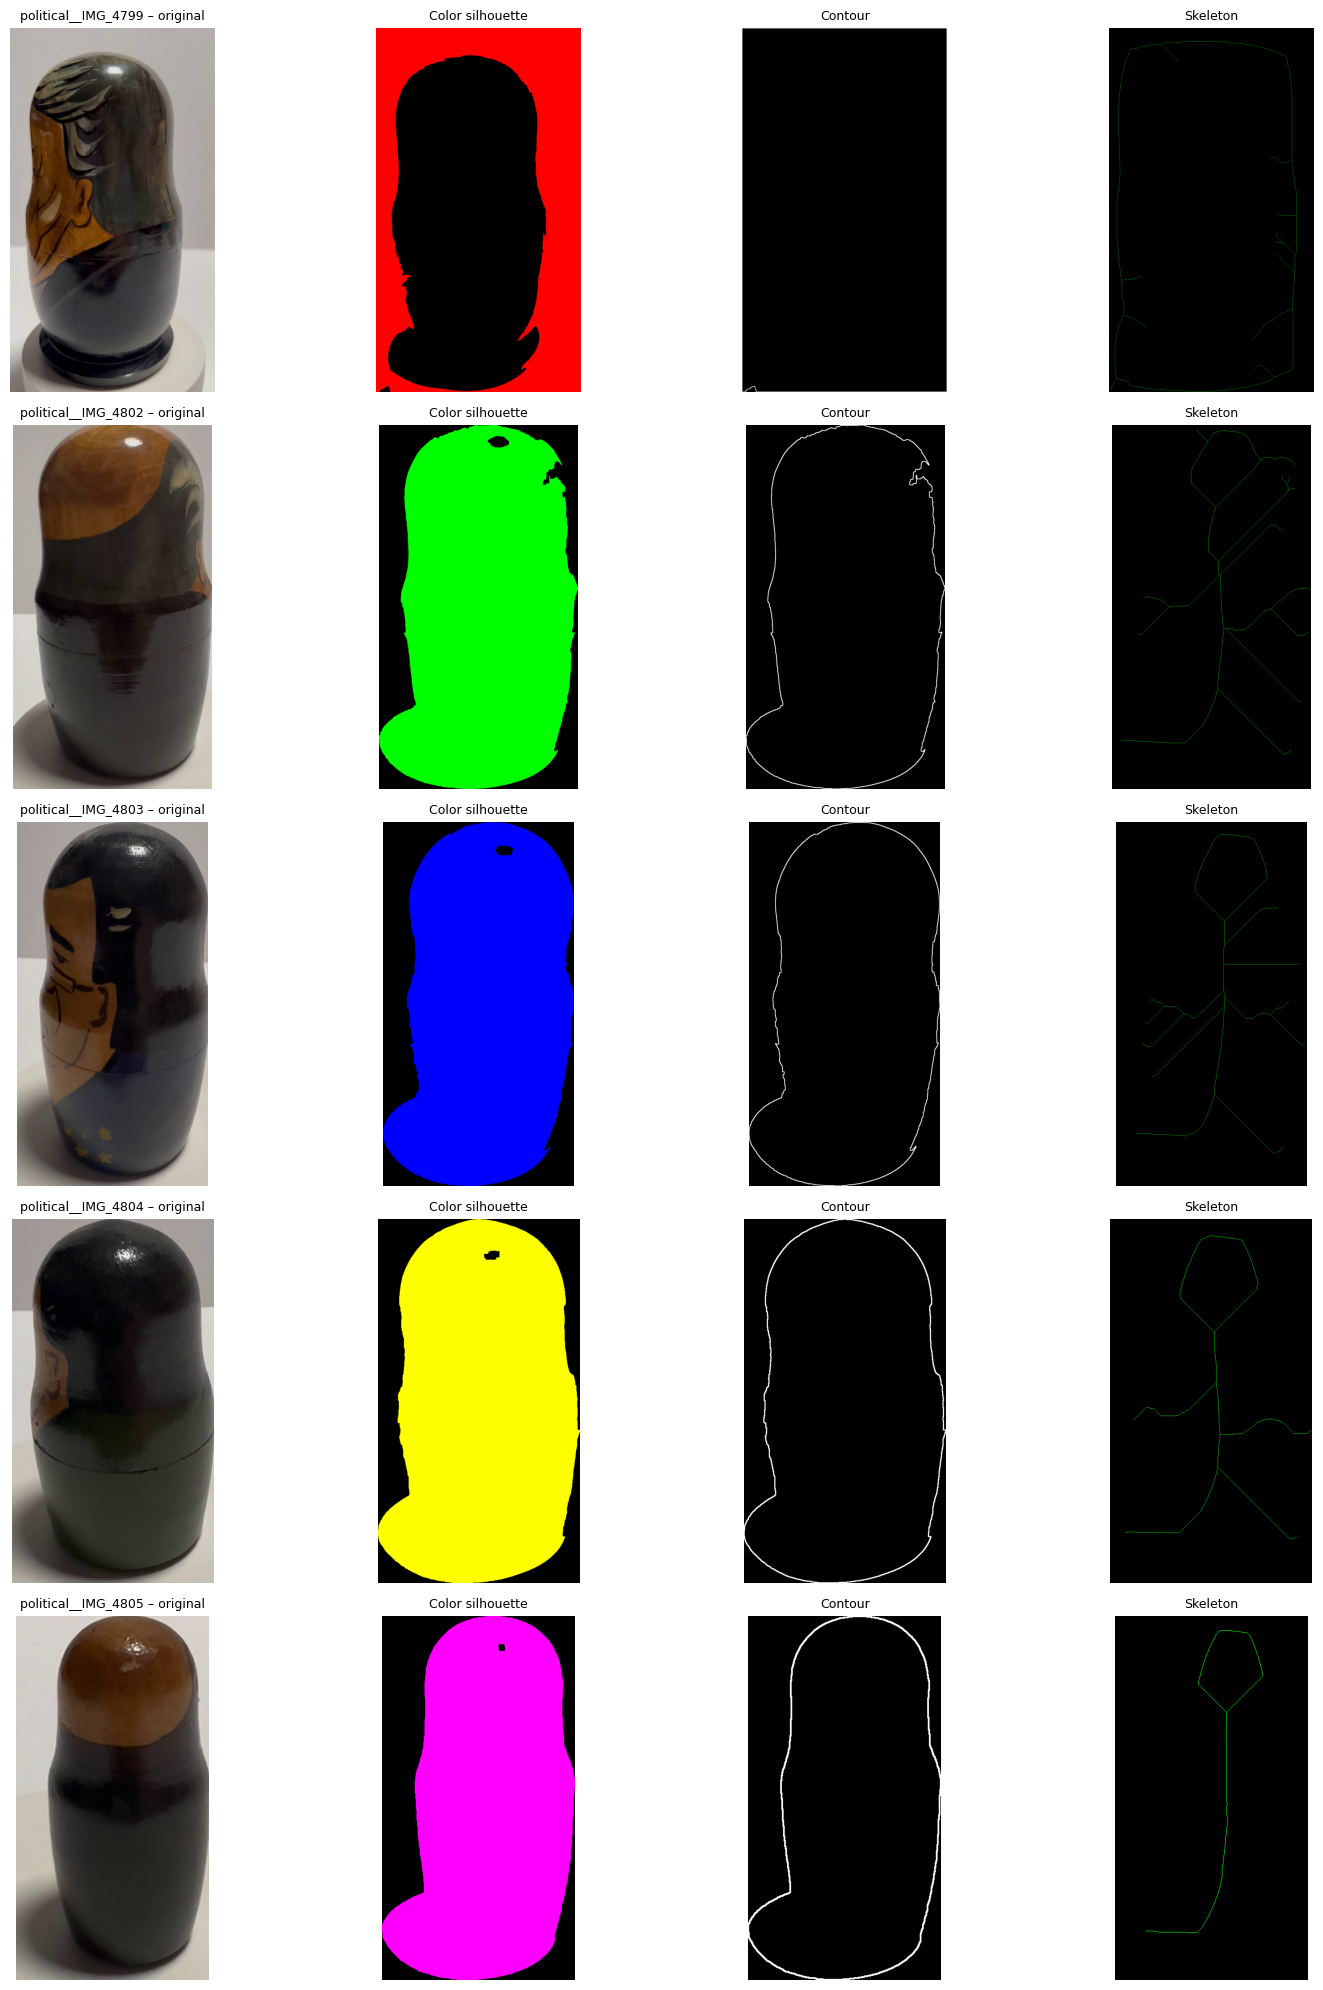

Grid saved to: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_2d_full/political_family_grid_original_color_contour_skeleton.png


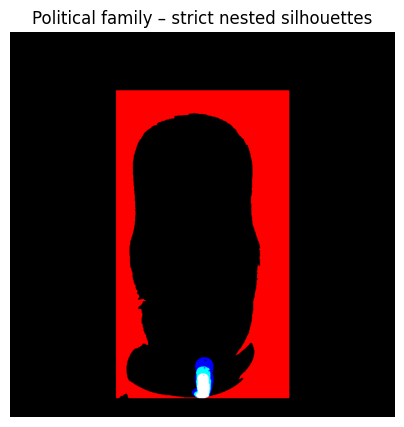

Nested silhouettes saved to: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_2d_full/political_nested_silhouettes_strict.png


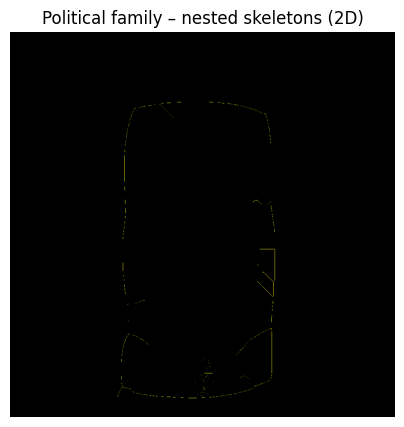

Nested skeletons saved to: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_2d_full/political_nested_skeletons.png


In [ ]:
# ============================================
# Matryoshka – Political family 2D analysis
#   • Pick up to 5 political dolls
#   • For each: original / color silhouette / contour / skeleton
#   • Show them on a grid
#   • Strictly nest dolls (2D) & overlap skeletons
# ============================================

!pip install -q opencv-python-headless matplotlib pandas scikit-image

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from skimage.morphology import skeletonize

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ------------ CONFIG ------------
# Use the PROJECT folder you printed in the multitask script
PROJECT = Path("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015")
META_CSV = PROJECT / "metadata.csv"

OUT_DIR = PROJECT / "political_2d_full"
OUT_DIR.mkdir(parents=True, exist_ok=True)

FOLDER_CANONICAL = "political"
MAX_DOLLS = 5

CANVAS_W = 1024
CANVAS_H = 1024
INNER_FRACTION = 0.85
CLEARANCE = 0.95
MAX_ITERS = 60

# BGR colors for silhouettes; RGBA for skeleton overlays later
COLOR_TABLE_BGR = [
    (0,   0, 255),  # red
    (0, 255,   0),  # green
    (255, 0,   0),  # blue
    (0, 255, 255),  # yellow
    (255, 0, 255),  # magenta
]
COLOR_TABLE_RGBA = [
    (255,   0,   0, 255),
    (  0, 255,   0, 255),
    (  0,   0, 255, 255),
    (255, 255,   0, 255),
    (255,   0, 255, 255),
]

# ------------ HELPERS ------------

def pick_representative_frame(df_group):
    """Pick middle frame of a set_id group."""
    df_group = df_group.sort_values("frame_idx")
    return df_group.iloc[len(df_group) // 2]

def extract_silhouette(img_bgr):
    """
    Create a binary mask of the main object via thresholding +
    largest connected component.
    Returns mask (uint8, 0 or 255).
    """
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)

    _, mask = cv2.threshold(
        gray_blur, 0, 255,
        cv2.THRESH_BINARY + cv2.THRESH_OTSU
    )
    # If background is mostly white → invert
    if np.mean(mask) > 127:
        mask = 255 - mask

    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        areas = stats[1:, cv2.CC_STAT_AREA]
        largest_label = 1 + np.argmax(areas)
        mask2 = np.zeros_like(mask)
        mask2[labels == largest_label] = 255
        mask = mask2

    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask

def make_contour_image(mask_cropped, color=(255, 255, 255)):
    """Return an RGB image with only the contours drawn."""
    h, w = mask_cropped.shape
    img = np.zeros((h, w, 3), dtype=np.uint8)
    contours, _ = cv2.findContours(mask_cropped, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(img, contours, -1, color, thickness=2)
    return img

def make_skeleton_image(mask_cropped, color=(0, 255, 0)):
    """Return an RGB image with the skeleton drawn."""
    binary = (mask_cropped > 0)
    skel = skeletonize(binary)  # bool
    skel_u8 = (skel.astype(np.uint8) * 255)

    h, w = skel_u8.shape
    img = np.zeros((h, w, 3), dtype=np.uint8)
    for c in range(3):
        img[..., c] = np.where(skel_u8 > 0, color[c], 0)
    return img, skel_u8

# ------------ 1) Load metadata & pick political dolls ------------
meta = pd.read_csv(META_CSV)
pol = meta[meta["folder_canonical"] == FOLDER_CANONICAL].copy()
assert not pol.empty, "No political frames found in metadata.csv"

set_ids = pol["set_id"].unique().tolist()
set_ids = set_ids[:MAX_DOLLS]

picked_rows = []
for sid in set_ids:
    g = pol[pol["set_id"] == sid]
    picked_rows.append(pick_representative_frame(g))

picked_df = pd.DataFrame(picked_rows)

print("Selected political dolls (set_id, frame_idx):")
print(picked_df[["set_id", "frame_idx"]])

# ------------ 2) Build per-doll data: original / silhouette / contour / skeleton ------------

dolls = []  # list of dicts

for i, (_, row) in enumerate(picked_df.iterrows()):
    img = cv2.imread(row["frame_path"])
    mask = extract_silhouette(img)

    ys, xs = np.where(mask > 0)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()

    # cropped original
    orig_crop = img[y_min:y_max+1, x_min:x_max+1]

    # cropped mask
    mask_crop = mask[y_min:y_max+1, x_min:x_max+1]
    h, w = mask_crop.shape

    # single-color silhouette
    color = COLOR_TABLE_BGR[i % len(COLOR_TABLE_BGR)]
    sil_color = np.zeros_like(orig_crop)
    for c in range(3):
        sil_color[..., c] = np.where(mask_crop > 0, color[c], 0)

    # contour image
    contour_img = make_contour_image(mask_crop, color=(255, 255, 255))

    # skeleton image + binary skeleton
    skel_img, skel_bin = make_skeleton_image(mask_crop, color=(0, 255, 0))

    dolls.append({
        "set_id": row["set_id"],
        "frame_path": row["frame_path"],
        "orig_crop": orig_crop,
        "mask_crop": mask_crop,
        "sil_color": sil_color,
        "contour_img": contour_img,
        "skel_img": skel_img,
        "skel_bin": skel_bin,
        "height": h,
        "width": w,
        "color_bgr": color,
    })

# ------------ 3) GRID: Original | Color silhouette | Contour | Skeleton ------------

n = len(dolls)
fig, axes = plt.subplots(n, 4, figsize=(4 * 4, 4 * n))
if n == 1:
    axes = np.expand_dims(axes, axis=0)

for i, doll in enumerate(dolls):
    # Original
    ax = axes[i, 0]
    ax.imshow(cv2.cvtColor(doll["orig_crop"], cv2.COLOR_BGR2RGB))
    ax.set_title(f"{doll['set_id']} – original", fontsize=9)
    ax.axis("off")

    # Color silhouette
    ax = axes[i, 1]
    ax.imshow(cv2.cvtColor(doll["sil_color"], cv2.COLOR_BGR2RGB))
    ax.set_title("Color silhouette", fontsize=9)
    ax.axis("off")

    # Contour
    ax = axes[i, 2]
    ax.imshow(doll["contour_img"])
    ax.set_title("Contour", fontsize=9)
    ax.axis("off")

    # Skeleton
    ax = axes[i, 3]
    ax.imshow(doll["skel_img"])
    ax.set_title("Skeleton", fontsize=9)
    ax.axis("off")

plt.tight_layout()
grid_path = OUT_DIR / "political_family_grid_original_color_contour_skeleton.png"
plt.savefig(grid_path, dpi=200)
plt.show()
print("Grid saved to:", grid_path)

# ------------ 4) STRICT nesting in 2D (using silhouettes) & skeleton overlap ------------

# Sort dolls largest → smallest by height
dolls_sorted = sorted(dolls, key=lambda d: d["height"], reverse=True)

canvas_center_x = CANVAS_W // 2
base_y = CANVAS_H - 50

nested_sil_canvases = []
nested_skel_canvases = []
prev_outer_mask_canvas = None
prev_outer_height = None
prev_outer_width = None

for idx, doll in enumerate(dolls_sorted):
    mask = doll["mask_crop"]
    skel = doll["skel_bin"]
    h, w = mask.shape

    # initial scale guess
    if idx == 0:
        target_h = int(CANVAS_H * 0.80)
        scale = target_h / float(h)
    else:
        if prev_outer_height is None or prev_outer_width is None:
            scale = 0.5
        else:
            scale_h = (prev_outer_height * INNER_FRACTION) / h
            scale_w = (prev_outer_width * INNER_FRACTION) / w
            scale = CLEARANCE * min(scale_h, scale_w)

    # iteratively shrink until inside previous outer mask
    for it in range(MAX_ITERS):
        new_h = max(1, int(round(h * scale)))
        new_w = max(1, int(round(w * scale)))

        mask_resized = cv2.resize(mask, (new_w, new_h), interpolation=cv2.INTER_NEAREST)
        skel_resized = cv2.resize(skel, (new_w, new_h), interpolation=cv2.INTER_NEAREST)

        mask_canvas = np.zeros((CANVAS_H, CANVAS_W), dtype=np.uint8)
        skel_canvas = np.zeros((CANVAS_H, CANVAS_W), dtype=np.uint8)

        x0 = canvas_center_x - new_w // 2
        y0 = base_y - new_h

        x0 = max(0, x0)
        y0 = max(0, y0)
        x1 = min(x0 + new_w, CANVAS_W)
        y1 = min(y0 + new_h, CANVAS_H)
        sx1 = x1 - x0
        sy1 = y1 - y0

        mask_canvas[y0:y1, x0:x1] = mask_resized[:sy1, :sx1]
        skel_canvas[y0:y1, x0:x1] = skel_resized[:sy1, :sx1]

        if idx == 0 or prev_outer_mask_canvas is None:
            break
        else:
            outside = (mask_canvas > 0) & (prev_outer_mask_canvas == 0)
            if outside.any():
                scale *= 0.97
                continue
            else:
                break

    # store for next doll
    prev_outer_height = new_h
    prev_outer_width = new_w
    prev_outer_mask_canvas = mask_canvas.copy()

    # build colored silhouette canvas for this doll
    color = doll["color_bgr"]
    sil_canvas_color = np.zeros((CANVAS_H, CANVAS_W, 3), dtype=np.uint8)
    for c in range(3):
        sil_canvas_color[..., c] = np.where(mask_canvas > 0, color[c], 0)

    # skeleton colored (cyan for visibility)
    skel_canvas_color = np.zeros((CANVAS_H, CANVAS_W, 3), dtype=np.uint8)
    skel_color = (0, 255, 255)
    for c in range(3):
        skel_canvas_color[..., c] = np.where(skel_canvas > 0, skel_color[c], 0)

    nested_sil_canvases.append(sil_canvas_color)
    nested_skel_canvases.append(skel_canvas_color)

    # save per-doll nested views
    cv2.imwrite(str(OUT_DIR / f"{idx:02d}_{doll['set_id']}_nested_silhouette.png"),
                sil_canvas_color)
    cv2.imwrite(str(OUT_DIR / f"{idx:02d}_{doll['set_id']}_nested_skeleton.png"),
                skel_canvas_color)

# ------------ 5) Overlap (a) silhouettes and (b) skeletons ------------

# (a) silhouettes overlap
overlap_sil = np.zeros((CANVAS_H, CANVAS_W, 3), dtype=np.uint8)
for sil in nested_sil_canvases:
    overlap_sil = np.maximum(overlap_sil, sil)

sil_path = OUT_DIR / "political_nested_silhouettes_strict.png"
cv2.imwrite(str(sil_path), overlap_sil)
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(overlap_sil, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Political family – strict nested silhouettes")
plt.show()
print("Nested silhouettes saved to:", sil_path)

# (b) skeleton overlap
overlap_skel = np.zeros((CANVAS_H, CANVAS_W, 3), dtype=np.uint8)
for skel in nested_skel_canvases:
    overlap_skel = np.maximum(overlap_skel, skel)

skel_path = OUT_DIR / "political_nested_skeletons.png"
cv2.imwrite(str(skel_path), overlap_skel)
plt.figure(figsize=(5, 5))
plt.imshow(cv2.cvtColor(overlap_skel, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Political family – nested skeletons (2D)")
plt.show()
print("Nested skeletons saved to:", skel_path)


Mounted at /content/drive
Selected political dolls:
                    set_id  frame_idx
17951  political__IMG_4799         77
18112  political__IMG_4802         83
18272  political__IMG_4803         77
18425  political__IMG_4804         76
18579  political__IMG_4805         77


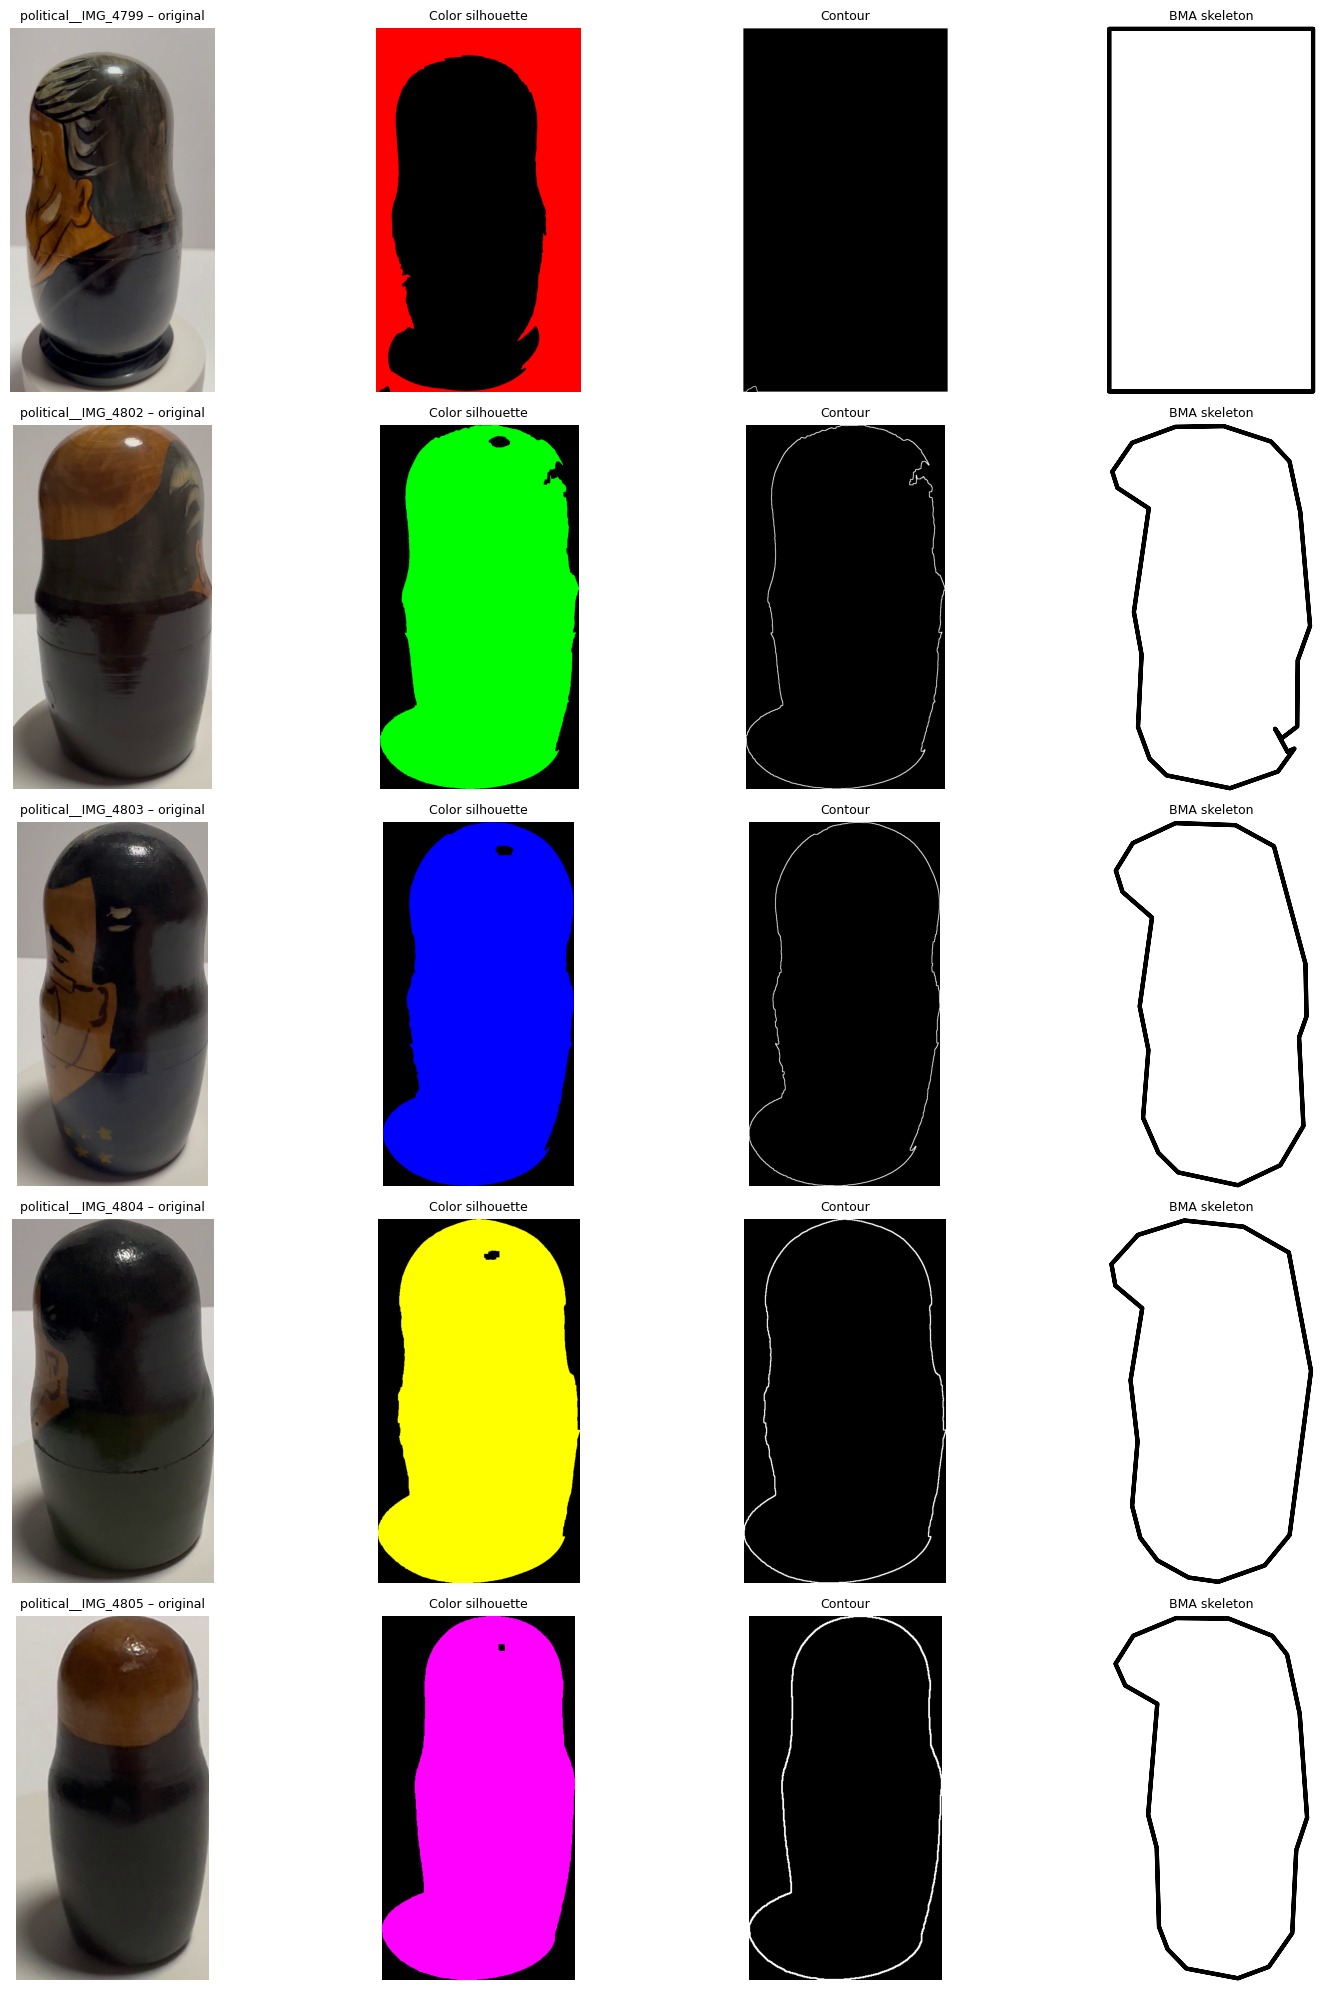

Grid saved to: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_bma_2d/political_grid_original_silhouette_contour_bma.png


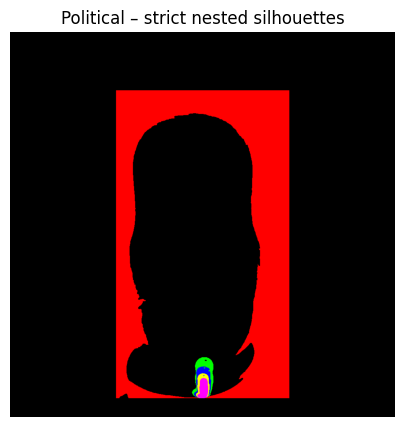

Nested silhouettes saved to: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_bma_2d/political_nested_silhouettes_strict.png


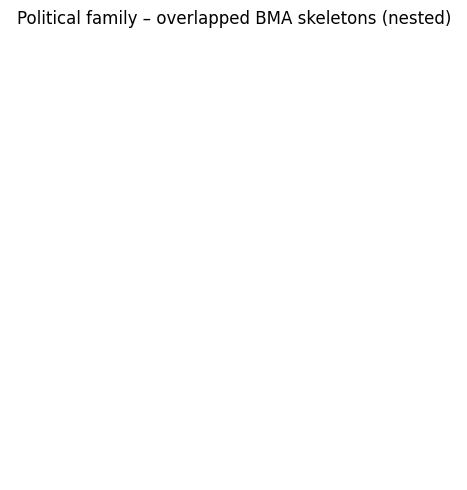

Nested BMA skeletons saved to: /content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015/political_bma_2d/political_nested_bma_skeletons.png


In [ ]:
# ============================================================
# Matryoshka Political Family – BMA Skeletons (2D only)
# Uses your EXACT Blum Medial Axis skeleton code for skeletons
# Grid: Original | Color silhouette | Contour | BMA Skeleton
# Then: strict nesting + overlapped BMA skeletons
# ============================================================

!pip install -q opencv-python-headless matplotlib pandas scipy

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path as FSPath  # filesystem paths

from scipy.spatial import Delaunay
from scipy.sparse import csr_matrix
from typing import List, Tuple

from matplotlib.patches import Polygon, PathPatch
from matplotlib.path import Path
from matplotlib.collections import LineCollection

# ------------------------------------------------------------
# 0. YOUR BMA CORE (copied as-is, just without TF / MNIST)
# ------------------------------------------------------------

def calculate_medial_axis_py(z: np.ndarray) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Calculates medial axis data using complex numbers (z = x + iy)."""
    points = np.column_stack((np.real(z), np.imag(z)))
    delaunay = Delaunay(points)
    tri = delaunay.simplices

    max_z_idx = len(z) - 1
    valid_tri_mask = (tri[:, 0] <= max_z_idx) & (tri[:, 1] <= max_z_idx) & (tri[:, 2] <= max_z_idx)
    tri = tri[valid_tri_mask]

    u, v, w = z[tri[:, 0]], z[tri[:, 1]], z[tri[:, 2]]
    dot = (u - w) * np.conj(v - w)
    imag_dot = np.imag(dot)
    safe_imag_dot = np.where(imag_dot == 0, 1e-9, imag_dot)

    m = (u + v + 1j * (u - v) * np.real(dot) / safe_imag_dot) / 2
    r = np.abs(u - m)

    inside = imag_dot > 0
    m, r, triin = m[inside], r[inside], tri[inside]

    return z, np.column_stack((m, r, triin.real)), r, triin.real

def calculate_medial_order_py(medial_data: np.ndarray) -> np.ndarray:
    """Connects medial points (circumcenters) that share a boundary edge."""
    m2 = medial_data[:, 0]
    triin2 = np.column_stack((medial_data[:, 2].astype(int),
                              medial_data[:, 3].astype(int),
                              medial_data[:, 4].astype(int)))

    nt = triin2.shape[0]
    max_col_idx = np.max(triin2) + 1

    B1 = csr_matrix((np.ones(3 * nt), (np.repeat(np.arange(nt), 3), triin2.flatten())), shape=(nt, max_col_idx))
    B1_product = B1 @ B1.transpose()
    B1_dense = B1_product.toarray()

    a1, b1 = np.where(B1_dense > 1)
    ind = a1 > b1
    a1, b1 = a1[ind], b1[ind]

    return np.vstack((m2[a1], m2[b1])).T

class BlumMedialAxis_py:
    def __init__(self, boundary: np.ndarray):
        self.pointsArray = []
        self.adjacencyMatrix = np.array([])
        self.boundary = boundary

        if boundary is not None and len(boundary) > 2:
            boundary, medial_data, _, _ = calculate_medial_axis_py(boundary)

            if medial_data.size == 0:
                self.adjacencyMatrix = np.zeros((0, 0), dtype=bool)
                return

            connected_point_pairs = calculate_medial_order_py(medial_data)

            point_to_index = {}

            def find_or_add(point_complex):
                point_tuple = (np.round(point_complex.real, 4), np.round(point_complex.imag, 4))
                if point_tuple in point_to_index:
                    return point_to_index[point_tuple]

                new_index = len(self.pointsArray)
                self.pointsArray.append(point_complex)
                point_to_index[point_tuple] = new_index
                return new_index

            for pair in connected_point_pairs:
                p_a = pair[0]
                p_b = pair[1]

                idx_m = find_or_add(p_a)
                idx_n = find_or_add(p_b)

                if idx_m != idx_n:
                    num_points = len(self.pointsArray)
                    if num_points > self.adjacencyMatrix.shape[0]:
                        old_size = self.adjacencyMatrix.shape[0]
                        new_matrix = np.zeros((num_points, num_points), dtype=bool)
                        if old_size > 0:
                            new_matrix[:old_size, :old_size] = self.adjacencyMatrix
                        self.adjacencyMatrix = new_matrix

                    self.adjacencyMatrix[idx_m, idx_n] = True
                    self.adjacencyMatrix[idx_n, idx_m] = True

        if not self.pointsArray:
            self.adjacencyMatrix = np.zeros((0, 0), dtype=bool)

# ---- plotting helpers from your code ----
EXPANSION_UNIT = 1.0
PAD = 3.0

def _ensure_closed(z):
    z = np.asarray(z, dtype=np.complex128).ravel()
    if z.size and abs(z[0]-z[-1]) > 1e-12:
        z = np.concatenate([z, z[:1]])
    return z

def _bounds_xy(z):
    z = _ensure_closed(z)
    xy = np.column_stack([z.real, z.imag]).astype(float)
    xmin, ymin = xy.min(0); xmax, ymax = xy.max(0)
    return float(xmin), float(xmax), float(ymin), float(ymax), xy

def _closed_pathpatch_double_cycle(xy: np.ndarray, lw: float, edge='k', face='none', z=20, cycles: int = 2):
    ring = xy[:-1] if np.allclose(xy[0], xy[-1]) else xy
    tiled = np.vstack([ring] * cycles)

    n = len(tiled)
    verts = np.vstack([tiled, tiled[0]])
    codes = np.empty(n + 1, dtype=np.uint8)
    codes[0] = Path.MOVETO
    codes[1:n] = Path.LINETO
    codes[n] = Path.CLOSEPOLY

    path = Path(verts, codes)
    pp = PathPatch(
        path, facecolor=face, edgecolor=edge, linewidth=lw,
        joinstyle='round', capstyle='round', antialiased=True, zorder=z
    )
    pp.set_clip_on(False)
    pp.set_snap(False)
    return pp

def bma_plot_double_cycle(ax, bma_data, point_size=2.0, edge_alpha=0.7,
                          lw_outer=3.5, lw_inner=1.5, cycles=2):
    """Plots the skeleton and boundary using the double-cycle technique."""
    xmin, xmax, ymin, ymax, xy = _bounds_xy(bma_data.boundary)

    xmin_expanded = xmin - EXPANSION_UNIT

    # 1. white fill
    poly_fill = Polygon(xy, closed=True, facecolor='white',
                        edgecolor='none', zorder=1, clip_on=False)
    ax.add_patch(poly_fill)

    # 2. skeleton (green) + medial points (red)
    if len(bma_data.pointsArray):
        bma_points_array = np.array(bma_data.pointsArray)

        row, col = np.where(bma_data.adjacencyMatrix)
        for r, c in zip(row, col):
            if r < c:
                a = bma_points_array[r]; b = bma_points_array[c]
                ax.plot([a.real, b.real], [a.imag, b.imag], '-',
                        linewidth=0.6, alpha=edge_alpha,
                        color='tab:green', zorder=5, clip_on=False)

        ax.plot(bma_points_array.real, bma_points_array.imag, 'r.',
                markersize=point_size, zorder=6, clip_on=False)

    # 3. double boundary stroke
    ax.add_patch(_closed_pathpatch_double_cycle(xy, lw=lw_outer, edge='k',
                                                face='none', z=20, cycles=cycles))
    ax.add_patch(_closed_pathpatch_double_cycle(xy, lw=lw_inner, edge='k',
                                                face='none', z=21, cycles=cycles))

    ax.set_xlim(xmin_expanded - PAD, xmax + PAD)
    ax.set_ylim(ymax + PAD, ymin - PAD)
    ax.invert_yaxis()
    ax.set_aspect('equal', adjustable='box')
    ax.axis('off')
    ax.set_facecolor('white')

# ------------------------------------------------------------
# 1. MATRYOSHKA DATA – political family
# ------------------------------------------------------------

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# ⚠️ Update PROJECT if your timestamp changed:
PROJECT = FSPath("/content/drive/MyDrive/Matreskas/matryoshka_smd2_20251119_103015")
META_CSV = PROJECT / "metadata.csv"
OUT_DIR = PROJECT / "political_bma_2d"

OUT_DIR.mkdir(parents=True, exist_ok=True)

FOLDER_CANONICAL = "political"
MAX_DOLLS = 5

CANVAS_W = 1024
CANVAS_H = 1024
INNER_FRACTION = 0.85
CLEARANCE = 0.95
MAX_ITERS = 60

COLOR_TABLE_BGR = [
    (0,   0, 255),
    (0, 255,   0),
    (255, 0,   0),
    (0, 255, 255),
    (255, 0, 255),
]

COLOR_TABLE_MPL = [
    "red", "lime", "blue", "gold", "magenta"
]

meta = pd.read_csv(META_CSV)
pol = meta[meta["folder_canonical"] == FOLDER_CANONICAL].copy()
assert not pol.empty, "No political frames found."

set_ids = pol["set_id"].unique().tolist()[:MAX_DOLLS]

def pick_rep_frame(df_group):
    df_group = df_group.sort_values("frame_idx")
    return df_group.iloc[len(df_group)//2]

picked_rows = []
for sid in set_ids:
    picked_rows.append(pick_rep_frame(pol[pol["set_id"] == sid]))
picked_df = pd.DataFrame(picked_rows)

print("Selected political dolls:")
print(picked_df[["set_id", "frame_idx"]])

# ------------------------------------------------------------
# 2. SILHOUETTES + BMA SKELETONS PER DOLL
# ------------------------------------------------------------

def extract_silhouette(img_bgr):
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    gray_blur = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(gray_blur, 0, 255,
                            cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    if np.mean(mask) > 127:
        mask = 255 - mask
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask, connectivity=8)
    if num_labels > 1:
        areas = stats[1:, cv2.CC_STAT_AREA]
        largest_label = 1 + np.argmax(areas)
        mask2 = np.zeros_like(mask)
        mask2[labels == largest_label] = 255
        mask = mask2
    kernel = np.ones((5, 5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=2)
    return mask

dolls = []

for i, (_, row) in enumerate(picked_df.iterrows()):
    img = cv2.imread(row["frame_path"])
    mask = extract_silhouette(img)

    ys, xs = np.where(mask > 0)
    y_min, y_max = ys.min(), ys.max()
    x_min, x_max = xs.min(), xs.max()

    orig_crop = img[y_min:y_max+1, x_min:x_max+1]
    mask_crop = mask[y_min:y_max+1, x_min:x_max+1]
    h, w = mask_crop.shape

    color = COLOR_TABLE_BGR[i % len(COLOR_TABLE_BGR)]
    sil_color = np.zeros_like(orig_crop)
    for c in range(3):
        sil_color[..., c] = np.where(mask_crop > 0, color[c], 0)

    contours, _ = cv2.findContours(mask_crop, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_img = np.zeros((h, w, 3), dtype=np.uint8)
    cv2.drawContours(contour_img, contours, -1, (255, 255, 255), thickness=2)

    # ----- BMA skeleton using your code -----
    bma_instance = None
    if contours:
        largest = max(contours, key=cv2.contourArea)
        epsilon = 0.005 * cv2.arcLength(largest, True)
        simplified = cv2.approxPolyDP(largest, epsilon, True)

        if simplified.ndim == 3 and simplified.shape[0] > 2:
            boundary_complex = simplified[:, 0, 0] + 1j * simplified[:, 0, 1]
            bma_instance = BlumMedialAxis_py(boundary_complex)

    dolls.append({
        "set_id": row["set_id"],
        "frame_path": row["frame_path"],
        "orig_crop": orig_crop,
        "mask_crop": mask_crop,
        "sil_color": sil_color,
        "contour_img": contour_img,
        "bma": bma_instance,
        "height": h,
        "width": w,
    })

# ------------------------------------------------------------
# 3. GRID: Original | Color silhouette | Contour | BMA Skeleton
# ------------------------------------------------------------

n = len(dolls)
fig, axes = plt.subplots(n, 4, figsize=(4*4, 4*n))
if n == 1:
    axes = np.expand_dims(axes, axis=0)

for i, doll in enumerate(dolls):
    # Original
    ax = axes[i, 0]
    ax.imshow(cv2.cvtColor(doll["orig_crop"], cv2.COLOR_BGR2RGB))
    ax.set_title(f"{doll['set_id']} – original", fontsize=9)
    ax.axis("off")

    # Color silhouette
    ax = axes[i, 1]
    ax.imshow(cv2.cvtColor(doll["sil_color"], cv2.COLOR_BGR2RGB))
    ax.set_title("Color silhouette", fontsize=9)
    ax.axis("off")

    # Contour
    ax = axes[i, 2]
    ax.imshow(doll["contour_img"])
    ax.set_title("Contour", fontsize=9)
    ax.axis("off")

    # BMA skeleton using your plotting function
    ax = axes[i, 3]
    bma = doll["bma"]
    if bma is not None and bma.boundary is not None and len(bma.boundary) > 2:
        bma_plot_double_cycle(ax, bma, point_size=3.0, edge_alpha=0.8,
                              lw_outer=3.0, lw_inner=1.5, cycles=2)
        ax.set_title("BMA skeleton", fontsize=9)
    else:
        ax.imshow(doll["sil_color"][..., ::-1])
        ax.set_title("BMA failed – silhouette", fontsize=9)
        ax.axis("off")

plt.tight_layout()
grid_path = OUT_DIR / "political_grid_original_silhouette_contour_bma.png"
plt.savefig(grid_path, dpi=200)
plt.show()
print("Grid saved to:", grid_path)

# ------------------------------------------------------------
# 4. STRICT NESTING (2D) USING SILHOUETTES + BMA SKELETON OVERLAP
# ------------------------------------------------------------

dolls_sorted = sorted(dolls, key=lambda d: d["height"], reverse=True)
canvas_center_x = CANVAS_W // 2
base_y = CANVAS_H - 50

prev_outer_mask = None
prev_outer_height = None
prev_outer_width = None

nested_infos = []

for idx, doll in enumerate(dolls_sorted):
    mask = doll["mask_crop"]
    h, w = mask.shape

    # initial scale guess
    if idx == 0:
        target_h = int(CANVAS_H * 0.80)
        scale_pix = target_h / float(h)
    else:
        if prev_outer_height is None or prev_outer_width is None:
            scale_pix = 0.5
        else:
            scale_h = (prev_outer_height * INNER_FRACTION) / h
            scale_w = (prev_outer_width * INNER_FRACTION) / w
            scale_pix = CLEARANCE * min(scale_h, scale_w)

    for it in range(MAX_ITERS):
        new_h = max(1, int(round(h * scale_pix)))
        new_w = max(1, int(round(w * scale_pix)))

        mask_resized = cv2.resize(mask, (new_w, new_h),
                                  interpolation=cv2.INTER_NEAREST)
        mask_canvas = np.zeros((CANVAS_H, CANVAS_W), dtype=np.uint8)

        x0 = canvas_center_x - new_w // 2
        y0 = base_y - new_h

        x0 = max(0, x0)
        y0 = max(0, y0)
        x1 = min(x0 + new_w, CANVAS_W)
        y1 = min(y0 + new_h, CANVAS_H)
        sx1 = x1 - x0
        sy1 = y1 - y0

        mask_canvas[y0:y1, x0:x1] = mask_resized[:sy1, :sx1]

        if idx == 0 or prev_outer_mask is None:
            break
        else:
            outside = (mask_canvas > 0) & (prev_outer_mask == 0)
            if outside.any():
                scale_pix *= 0.97
                continue
            else:
                break

    prev_outer_height = new_h
    prev_outer_width = new_w
    prev_outer_mask = mask_canvas.copy()

    nested_infos.append({
        "doll": doll,
        "mask_canvas": mask_canvas,
        "x0": x0, "y0": y0,
        "new_w": new_w, "new_h": new_h,
        "orig_w": w, "orig_h": h,
    })

# ---- overlapped silhouettes ----
overlap_sil = np.zeros((CANVAS_H, CANVAS_W, 3), dtype=np.uint8)
for info_idx, info in enumerate(nested_infos):
    color = dolls_sorted[info_idx]["sil_color"][0,0,:].tolist()
    mask_canvas = info["mask_canvas"]
    for c in range(3):
        overlap_sil[..., c] = np.where(mask_canvas > 0,
                                       COLOR_TABLE_BGR[info_idx % len(COLOR_TABLE_BGR)][c],
                                       overlap_sil[..., c])

sil_path = OUT_DIR / "political_nested_silhouettes_strict.png"
cv2.imwrite(str(sil_path), overlap_sil)
plt.figure(figsize=(5,5))
plt.imshow(cv2.cvtColor(overlap_sil, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.title("Political – strict nested silhouettes")
plt.show()
print("Nested silhouettes saved to:", sil_path)

# ---- overlapped BMA skeletons (in nested coordinates) ----
fig, ax = plt.subplots(figsize=(5, 5))
ax.set_xlim(0, CANVAS_W)
ax.set_ylim(CANVAS_H, 0)
ax.set_aspect('equal')
ax.axis('off')
ax.set_facecolor('black')

for idx, info in enumerate(nested_infos):
    doll = info["doll"]
    bma = doll["bma"]
    if bma is None or not len(bma.pointsArray):
        continue

    pts = np.array(bma.pointsArray)
    A = pts.real
    B = pts.imag

    sx = info["new_w"] / float(info["orig_w"])
    sy = info["new_h"] / float(info["orig_h"])
    x0, y0 = info["x0"], info["y0"]

    rows, cols = np.where(bma.adjacencyMatrix)
    color = COLOR_TABLE_MPL[idx % len(COLOR_TABLE_MPL)]

    for r, c in zip(rows, cols):
        if r >= c:
            continue
        xa = x0 + A[r] * sx
        ya = y0 + B[r] * sy
        xb = x0 + A[c] * sx
        yb = y0 + B[c] * sy
        ax.plot([xa, xb], [ya, yb], color=color, linewidth=1.5, alpha=0.9)

ax.invert_yaxis()
ax.set_title("Political family – overlapped BMA skeletons (nested)", fontsize=12)

skel_path = OUT_DIR / "political_nested_bma_skeletons.png"
plt.tight_layout()
plt.savefig(skel_path, dpi=200)
plt.show()
print("Nested BMA skeletons saved to:", skel_path)
